# Bfastmonitor CPU using Python
## This is bfastmonitor Python

In [1]:
import os
import wget
import numpy as np
from datetime import datetime

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import copy

import matplotlib
import matplotlib.pyplot as plt

#from sar so extra
import csv
from shutil import copyfile
import pandas as pd
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

import time
import ipywidgets as widgets

from ipyfilechooser import FileChooser
import folium

#specific imports
from functions import set_output_dir, get_size, get_data_dict

In [2]:
%matplotlib inline

## Select a time series folder using ipyfilechooser. The standard download location is in downloads/time_series_name/[0,1,2..n]

### Optional: select a name for your output folder. 

In [3]:
from os.path import expanduser
path = expanduser("~")

def g(directory):
    return(directory)
                          
output_directory_chooser = widgets.interactive(g, 
                        directory=widgets.Text(description="Output storage name:", 
                                               style = {'description_width': 'initial'},
                                               placeholder = "output"))
file_chooser = FileChooser(path)

display(file_chooser)
display(output_directory_chooser)



FileChooser(path='/home/dven', filename='', title='HTML(value='', layout=Layout(display='none'))', show_hidden…

interactive(children=(Text(value='', description='Output storage name:', placeholder='output', style=Descripti…

In [4]:
timeseries_directory = file_chooser.selected

if not timeseries_directory:
    raise Exception("Please choose a time series directory above with the file selector")
else:
    print(timeseries_directory)
    set_output_dir(output_directory_chooser)

/home/dven/downloads/Time_series_2020-08-24_11-43-37_lake/0/
Defaulting to output directory name "output" 


In [ ]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from numpy import nan
from numpy import isnan

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import pyopencl

import inspect
        
import time

from datetime import datetime

from tqdm import tqdm

class Timeseries:
    '''
    
    This is a class that holds a numpy array with time series data, a csv containing dates, and associated geographical metadata.
    
    '''
    
    def __init__(self, time_series_path, dates_path):
        
        self.name = time_series_path + "stack.vrt"
        self.dir = time_series_path
        
        self.time_series = gdal.Open(self.name)
        #time_series = self.time_series
        geotransform = self.time_series.GetGeoTransform()
        
        # geo metadata
        self.xpixelsize = geotransform[1]
        self.ypixelsize = geotransform[5]
        self.latitude = geotransform[3]
        self.longitude = geotransform[0]
        self.ncols = self.time_series.RasterXSize
        self.nrows = self.time_series.RasterYSize
        self.projection = self.time_series.GetProjection()
        self.nbands = self.time_series.RasterCount
        
        band = self.time_series.GetRasterBand(1)
        self.block_size = band.GetBlockSize()
        self.time_dict = {}
        
        # self.raster_stack_orig = time_series.ReadAsArray()
        # This takes really long and will likely cause memory issues when running on large countries, so don't use it
        # Use blocks and base block size on what gdal sets or on ram calculation 
        
        # dates file
        with open(dates_path) as f:
            dates_list = f.read().split('\n')
            self.dates = [datetime.strptime(d, '%Y-%m-%d') for d in dates_list if len(d) > 0]
        
    def __str__(self):
        return("Timeseries holds {} dates, sized {} by {}.".format(self.nbands,
                                                                        self.ncols,
                                                                        self.nrows))
    def __repr__(self):
            return("Timeseries: {} ".format(self.name))

    def run_bfast(self, block):
        data, dates = crop_data_dates(block, self.dates, self.start_hist, self.end_monitor)

        # only apply on a small subset
        #data = data[:,:80,:80]
        
        # change nans to a number bfastmonitor-GPU can work with
        where_are_NaNs = isnan(data)
        data[where_are_NaNs] = -32768

        # fit model
        self.model.fit(data, dates, nan_value = -32768) 
        
        # save breaks and mean magnitudes
        breaks = self.model.breaks # index of date that has a break in dates
        means = self.model.means # magnitudes of breaks
        
        return(breaks,means)
    
    def loop_blocks(self):

        start_time = time.time()
        
        x_block_size = self.block_size[0]
        y_block_size = self.block_size[1]
        print("rastersize: ",self.ncols,self.nrows)
        print("The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize: ",self.block_size)
        print("set blocksize explicitly: ",x_block_size,", " ,y_block_size)
        print("bytes required: ", str(8 * self.ncols * self.nrows * self.nbands))
        print("start monitor: ", self.start_monitor)
        print("end monitor: ", self.end_monitor)
        print("start history: ", self.start_hist)
        
        
        first_verstack=True

        # loop over yblocks
        with tqdm(total=(self.ncols/x_block_size)*(self.nrows/y_block_size)) as pbar2:
            pbar2.set_description("Processing blocks of tile:")
                    
                
            for i in range(0, self.nrows, y_block_size):
                
                
                first_horstack = True
                if i + y_block_size < self.nrows:
                    rows = y_block_size
                else:
                    rows = self.nrows - i

                # Loop over xblocks
                for j in range(0, self.ncols, x_block_size):
                    
                    
                    if j + x_block_size < self.ncols:
                        cols = x_block_size
                    else:
                        cols = self.ncols - j

                    print(j,i,cols,rows)

                    # first step creates the array
                    pbar2.update(1)
                    
                    if first_horstack==True:
                        data = self.time_series.ReadAsArray(j, i, cols, rows).astype(np.int16)

                        breaks,means = self.run_bfast(data)
                        breaks_array = breaks
                        means_array = means
                        first_horstack=False

                    # after that add to array
                    else:                    
                        data = self.time_series.ReadAsArray(j, i, cols, rows).astype(np.int16)

                        breaks,means = self.run_bfast(data)
                        breaks_array = np.concatenate((breaks_array,breaks),axis = 1)
                        means_array = np.concatenate((means_array,means),axis = 1)
                
                
                # first step create new variable verstack for the data

                if first_verstack == True:
                    stack_breaks_array = breaks_array
                    stack_means_array = means_array
                    first_verstack = False
                
                # after that add data to array
                else:
                    stack_breaks_array = np.concatenate((stack_breaks_array,breaks_array),axis=0)
                    stack_means_array = np.concatenate((stack_means_array,means_array),axis=0)

            self.breaks_array = stack_breaks_array
            self.means_array = stack_means_array
            
            pbar2.close()
            end_time = time.time()
            print("Fitting model over all blocks took {} seconds.".format(end_time - start_time))
            self.time_dict[self.name] = str(end_time - start_time) + " seconds"

    def set_bfast_parameters(self, start_monitor, end_monitor, start_hist,freq,k,hfrac,trend,level,backend='opencl',verbose=1,device_id=0):
        self.start_monitor = start_monitor
        self.end_monitor = end_monitor
        self.start_hist = start_hist
        self.freq = freq
        self.k = k
        self.hfrac = hfrac
        self.trend = trend
        self.level = level
        self.backend = backend
        self.verbose = verbose
        
        self.model = BFASTMonitor(
                    self.start_monitor,
                    freq=freq, # add these
                    k=k,
                    hfrac=hfrac,
                    trend=trend,
                    level=level,
                    backend=backend,
                    verbose=verbose,
                    device_id=device_id,
                    )
        
        try:
            print(pyopencl.get_platforms()[0].get_devices())
        except:
            print("You selected  openCL, but no device was found, are you sure you set up a gpu session?")

    
    def get_bfast_parameters(self):
        print("Monitoring starts at: ", self.start_monitor)
        print("Monitoring ends at: ", self.end_monitor)
        print("Dataset history starts at: ", self.start_hist)
        print("frequency: ", self.freq)
        print("harmonic term: ", self.k)
        print("Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.: ", self.hfrac)
        print("Whether a tend offset term shall be used or not: ", self.trend)
        print("Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error: ", self.level)
        print("GPU opencl or CPU python: ", self.backend)
        print("The verbosity level (0=no output, 1=output): ", self.verbose)
        
    
    def log_output_to_txt(self):

        self.date = str(datetime.now())
        self.device = pyopencl.get_platforms()[0].get_devices()
        
        attributes = inspect.getmembers(self, lambda a:not(inspect.isroutine(a)))
        
        logs_directory = "logs"
        if not os.path.exists("logs"):
            os.makedirs(logs_directory)
        
        save_dir = self.dir
        try:
            start_index = save_dir.find("Time_series")
        except:
            start_index = 1
        save_dir = self.dir.replace("/","-")[start_index:] + datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + ".txt"
        
        
        with open(str(logs_directory + "/" + save_dir), "w") as f:
            for a in attributes:
                if not(a[0].startswith('__') and a[0].endswith('__')):
                    f.write(str(a))
                    f.write("\n")
    
    def log_breaks_means_arrays(self):
        
        arrays_directory = "output_arrays"
        if not os.path.exists("output_arrays"):
            os.makedirs(arrays_directory)
        
        
        
        
        with open()
        
    # Don't work anymore, fix later
    def plot_hist(self):
        histlist = []
        for x in range(self.nbands):
            histlist.append(np.isnan(self.raster_stack[x]).sum()/(self.ncols*self.nrows))
        plt.hist(histlist)
        plt.show()
        
    def get_size(self):
        total_size = 0
        for dirpath, dirnames, filenames in os.walk(self.dir):
            for f in filenames:
                fp = os.path.join(dirpath, f)
                # skip if it is symbolic link
                if not os.path.islink(fp):
                    total_size += os.path.getsize(fp)
        print(self.dir + "   holds  " + str(total_size) + " bytes")

      

# Load in data: if there are tiles in the directory, create a list and load per tile

In [130]:
# set paths to data
dates_path = os.path.join(timeseries_directory, "dates.csv")
data_list=[]
tile_paths = []

# check for tiles
file_list = os.listdir(timeseries_directory)
file_list.sort()
for file in file_list:
    if file.startswith('tile'):
        print(file)
        time_series_path =  timeseries_directory + file + "/"
        tile_paths.append(time_series_path)


tile-0000000000-0000000000
tile-0000000000-0000002048
tile-0000000000-0000004096
tile-0000002048-0000000000
tile-0000002048-0000002048
tile-0000002048-0000004096
tile-0000004096-0000000000
tile-0000004096-0000002048
tile-0000004096-0000004096


In [131]:
# # Set up list of time series tiles and their metadata
if not tile_paths:
    print("No tiles, setting up data as one tile")
    ts_data = Timeseries(timeseries_directory, dates_path)
    data_list.append(ts_data)
    
else:
    print("Data consists of tiles, setting up tiles")
    for time_series_path in tile_paths:
        ts_data = Timeseries(time_series_path, dates_path)
        data_list.append(ts_data)
        
# log
# with open("log.txt","a") as file:
#     file.write("Loading in: " + timeseries_directory)
#     file.write(" took {} seconds.".format(end_time - start_time))
#     file.write("\n")

Data consists of tiles, setting up tiles


### Check some metadata of the created Timeseries class

In [132]:
# data_list = data_list[0:2]
#ts_data = data_list[0]
print("projection: ", data_list[0].projection)
print("pixel size: ", data_list[0].xpixelsize)
#ts_data.log_output_to_txt()

# data_list = data_list[0:8]
# data_list

projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
pixel size:  0.00026949458523586184


# Set parameters

In [133]:
# parameters
k = 3
freq = 365
trend = False
hfrac = 0.25
level = 0.05
position = (100,100)

backend = 'opencl'
verbose = 1
device_id = 0


# start_hist = datetime(2018, 1, 1)
# start_monitor = datetime(2019, 1, 1)
# end_monitor = datetime(2020, 1, 1)


# Select monitoring period

In [134]:
dates = ts_data.dates
start_date = dates[10] # 0 or 10 does not work.. 100 did
print("start monitoring period",start_date)
end_date = dates[-1]

def h(y):
    return(y)

pandas_dates = pd.date_range(start_date, end_date, freq='D')

options =  [(date.strftime('%Y-%m-%d'),date) for date in pandas_dates]
index = (0, len(options)-1)


monitoring_period = widgets.interactive(h,
                                     y=widgets.SelectionRangeSlider(
                                            options=options,
                                            index=index,
                                            description='Select the monitoring date range: ',
                                            style = {'description_width': 'initial'},
                                            orientation='horizontal',
                                            layout={'width': '800px',"height":"50px"}))


history_period = widgets.interactive(h, 
                                     y=widgets.SelectionSlider(description="Start history period:", 
                                            options = options,
                                            style = {'description_width': 'initial'}))

display(monitoring_period)
display(history_period)

start monitoring period 2000-10-06 00:00:00


interactive(children=(SelectionRangeSlider(description='Select the monitoring date range: ', index=(0, 7240), …

interactive(children=(SelectionSlider(description='Start history period:', options=(('2000-10-06', Timestamp('…

In [135]:
start_monitor, end_monitor = monitoring_period.result
start_hist = history_period.result

if history_period.result > start_monitor:
    raise Exception("Your history period must start before the monitoring period")

#start_monitor = datetime(2011, 11, 23)

print("start monitor: ", start_monitor)
print("end monitor: ", end_monitor)
print("start history: ", start_hist)

start monitor:  2007-12-27 00:00:00
end monitor:  2020-08-02 00:00:00
start history:  2000-10-06 00:00:00


### if you have tiles loop over them, or select the first

In [136]:
from tqdm import tqdm
with tqdm(total=len(data_list)) as pbar1:
    pbar1.set_description("Processing tile %s out of %s" % (counter, len(data_list)) )
        
    for counter, ts_data in enumerate(data_list):
        ts_data.set_bfast_parameters(start_monitor,end_monitor,start_hist,freq,k,hfrac,trend,level,backend=backend,verbose=verbose,device_id=device_id)
        ts_data.loop_blocks()
        ts_data.get_bfast_parameters()
        ts_data.log_output_to_txt()
        pbar1.update(counter)
pbar.close()
# ts_data.set_bfast_parameters(start_monitor,end_monitor,start_hist,freq,k,hfrac,trend,level,backend,verbose,device_id)
# print(ts_data.start_monitor)

# ts_data.get_bfast_parameters()

Processing tile 0 out of 9:   0%|          | 0/9 [00:00<?, ?it/s]
  0%|          | 0/256.0 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/256.0 [00:00<?, ?it/s]

[<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x2e48420>]
rastersize:  2048 2048
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  128 ,  128
bytes required:  30500978688
start monitor:  2007-12-27 00:00:00
end monitor:  2020-08-02 00:00:00
start history:  2000-10-06 00:00:00
0 0 128 128



Processing blocks of tile::   1%|          | 2/256.0 [00:03<08:07,  1.92s/it]

--- runtime for data initialization:		0.002368450164794922
--- runtime for data transfer (host->device):	0.006841421127319336
--- runtime for data preprocessing:		0.002470731735229492
--- runtime for kernel execution:		0.008451223373413086
--- runtime for data transfer (device->host):	0.005045652389526367
128 0 128 128



Processing blocks of tile::   1%|          | 3/256.0 [00:07<10:33,  2.50s/it]

--- runtime for data initialization:		0.0023665428161621094
--- runtime for data transfer (host->device):	0.006777048110961914
--- runtime for data preprocessing:		0.0024671554565429688
--- runtime for kernel execution:		0.008273839950561523
--- runtime for data transfer (device->host):	0.0050504207611083984
256 0 128 128



Processing blocks of tile::   2%|▏         | 4/256.0 [00:11<12:17,  2.93s/it]

--- runtime for data initialization:		0.002328157424926758
--- runtime for data transfer (host->device):	0.006780147552490234
--- runtime for data preprocessing:		0.002475261688232422
--- runtime for kernel execution:		0.008297204971313477
--- runtime for data transfer (device->host):	0.005034923553466797
384 0 128 128



Processing blocks of tile::   2%|▏         | 5/256.0 [00:15<13:23,  3.20s/it]

--- runtime for data initialization:		0.002396821975708008
--- runtime for data transfer (host->device):	0.006768465042114258
--- runtime for data preprocessing:		0.002517223358154297
--- runtime for kernel execution:		0.008249282836914062
--- runtime for data transfer (device->host):	0.00504755973815918
512 0 128 128



Processing blocks of tile::   2%|▏         | 6/256.0 [00:19<14:09,  3.40s/it]

--- runtime for data initialization:		0.0023310184478759766
--- runtime for data transfer (host->device):	0.006811857223510742
--- runtime for data preprocessing:		0.002466917037963867
--- runtime for kernel execution:		0.008247613906860352
--- runtime for data transfer (device->host):	0.004881858825683594
640 0 128 128



Processing blocks of tile::   3%|▎         | 7/256.0 [00:23<14:41,  3.54s/it]

--- runtime for data initialization:		0.0023345947265625
--- runtime for data transfer (host->device):	0.0068132877349853516
--- runtime for data preprocessing:		0.002451658248901367
--- runtime for kernel execution:		0.008429527282714844
--- runtime for data transfer (device->host):	0.005057096481323242
768 0 128 128



Processing blocks of tile::   3%|▎         | 8/256.0 [00:27<15:07,  3.66s/it]

--- runtime for data initialization:		0.0023529529571533203
--- runtime for data transfer (host->device):	0.00672602653503418
--- runtime for data preprocessing:		0.0024971961975097656
--- runtime for kernel execution:		0.00845956802368164
--- runtime for data transfer (device->host):	0.0050508975982666016
896 0 128 128



Processing blocks of tile::   4%|▎         | 9/256.0 [00:30<15:17,  3.71s/it]

--- runtime for data initialization:		0.002300739288330078
--- runtime for data transfer (host->device):	0.006791830062866211
--- runtime for data preprocessing:		0.0024743080139160156
--- runtime for kernel execution:		0.008269786834716797
--- runtime for data transfer (device->host):	0.005044460296630859
1024 0 128 128



Processing blocks of tile::   4%|▍         | 10/256.0 [00:34<15:27,  3.77s/it]

--- runtime for data initialization:		0.0023920536041259766
--- runtime for data transfer (host->device):	0.006786346435546875
--- runtime for data preprocessing:		0.002462625503540039
--- runtime for kernel execution:		0.008279800415039062
--- runtime for data transfer (device->host):	0.005043506622314453
1152 0 128 128



Processing blocks of tile::   4%|▍         | 11/256.0 [00:38<15:29,  3.79s/it]

--- runtime for data initialization:		0.002365589141845703
--- runtime for data transfer (host->device):	0.006778240203857422
--- runtime for data preprocessing:		0.0024709701538085938
--- runtime for kernel execution:		0.00845646858215332
--- runtime for data transfer (device->host):	0.004886627197265625
1280 0 128 128



Processing blocks of tile::   5%|▍         | 12/256.0 [00:42<15:32,  3.82s/it]

--- runtime for data initialization:		0.002300262451171875
--- runtime for data transfer (host->device):	0.006732463836669922
--- runtime for data preprocessing:		0.002481698989868164
--- runtime for kernel execution:		0.008280038833618164
--- runtime for data transfer (device->host):	0.005033731460571289
1408 0 128 128



Processing blocks of tile::   5%|▌         | 13/256.0 [00:46<15:36,  3.85s/it]

--- runtime for data initialization:		0.002355337142944336
--- runtime for data transfer (host->device):	0.0068128108978271484
--- runtime for data preprocessing:		0.0024895668029785156
--- runtime for kernel execution:		0.008275508880615234
--- runtime for data transfer (device->host):	0.0050504207611083984
1536 0 128 128



Processing blocks of tile::   5%|▌         | 14/256.0 [00:50<15:30,  3.85s/it]

--- runtime for data initialization:		0.0024118423461914062
--- runtime for data transfer (host->device):	0.006734609603881836
--- runtime for data preprocessing:		0.0024785995483398438
--- runtime for kernel execution:		0.00827646255493164
--- runtime for data transfer (device->host):	0.005043745040893555
1664 0 128 128



Processing blocks of tile::   6%|▌         | 15/256.0 [00:54<15:28,  3.85s/it]

--- runtime for data initialization:		0.0023958683013916016
--- runtime for data transfer (host->device):	0.006762981414794922
--- runtime for data preprocessing:		0.002497434616088867
--- runtime for kernel execution:		0.008254051208496094
--- runtime for data transfer (device->host):	0.005053281784057617
1792 0 128 128



Processing blocks of tile::   6%|▋         | 16/256.0 [00:58<15:28,  3.87s/it]

--- runtime for data initialization:		0.0024263858795166016
--- runtime for data transfer (host->device):	0.0067822933197021484
--- runtime for data preprocessing:		0.002492189407348633
--- runtime for kernel execution:		0.008292913436889648
--- runtime for data transfer (device->host):	0.0050411224365234375
1920 0 128 128



Processing blocks of tile::   7%|▋         | 17/256.0 [01:02<15:25,  3.87s/it]

--- runtime for data initialization:		0.0023345947265625
--- runtime for data transfer (host->device):	0.006795406341552734
--- runtime for data preprocessing:		0.002478361129760742
--- runtime for kernel execution:		0.008411884307861328
--- runtime for data transfer (device->host):	0.005049705505371094
0 128 128 128



Processing blocks of tile::   7%|▋         | 18/256.0 [01:05<15:21,  3.87s/it]

--- runtime for data initialization:		0.0023491382598876953
--- runtime for data transfer (host->device):	0.006787538528442383
--- runtime for data preprocessing:		0.0024755001068115234
--- runtime for kernel execution:		0.008290767669677734
--- runtime for data transfer (device->host):	0.005045652389526367
128 128 128 128



Processing blocks of tile::   7%|▋         | 19/256.0 [01:09<15:13,  3.86s/it]

--- runtime for data initialization:		0.0023305416107177734
--- runtime for data transfer (host->device):	0.006793498992919922
--- runtime for data preprocessing:		0.0024614334106445312
--- runtime for kernel execution:		0.008235692977905273
--- runtime for data transfer (device->host):	0.004924297332763672
256 128 128 128



Processing blocks of tile::   8%|▊         | 20/256.0 [01:13<15:11,  3.86s/it]

--- runtime for data initialization:		0.0024232864379882812
--- runtime for data transfer (host->device):	0.0066983699798583984
--- runtime for data preprocessing:		0.002466917037963867
--- runtime for kernel execution:		0.008270263671875
--- runtime for data transfer (device->host):	0.005047798156738281
384 128 128 128



Processing blocks of tile::   8%|▊         | 21/256.0 [01:17<15:07,  3.86s/it]

--- runtime for data initialization:		0.002343893051147461
--- runtime for data transfer (host->device):	0.006795406341552734
--- runtime for data preprocessing:		0.0024733543395996094
--- runtime for kernel execution:		0.008442878723144531
--- runtime for data transfer (device->host):	0.00489354133605957
512 128 128 128



Processing blocks of tile::   9%|▊         | 22/256.0 [01:21<15:04,  3.86s/it]

--- runtime for data initialization:		0.0023348331451416016
--- runtime for data transfer (host->device):	0.006755828857421875
--- runtime for data preprocessing:		0.002471923828125
--- runtime for kernel execution:		0.008274316787719727
--- runtime for data transfer (device->host):	0.005037784576416016
640 128 128 128



Processing blocks of tile::   9%|▉         | 23/256.0 [01:25<14:57,  3.85s/it]

--- runtime for data initialization:		0.002289295196533203
--- runtime for data transfer (host->device):	0.006742954254150391
--- runtime for data preprocessing:		0.002472400665283203
--- runtime for kernel execution:		0.008249998092651367
--- runtime for data transfer (device->host):	0.004902839660644531
768 128 128 128



Processing blocks of tile::   9%|▉         | 24/256.0 [01:28<14:53,  3.85s/it]

--- runtime for data initialization:		0.002332448959350586
--- runtime for data transfer (host->device):	0.006791830062866211
--- runtime for data preprocessing:		0.0024755001068115234
--- runtime for kernel execution:		0.008269071578979492
--- runtime for data transfer (device->host):	0.005042552947998047
896 128 128 128



Processing blocks of tile::  10%|▉         | 25/256.0 [01:32<14:48,  3.85s/it]

--- runtime for data initialization:		0.002343893051147461
--- runtime for data transfer (host->device):	0.006806373596191406
--- runtime for data preprocessing:		0.0024688243865966797
--- runtime for kernel execution:		0.008297920227050781
--- runtime for data transfer (device->host):	0.005039215087890625
1024 128 128 128



Processing blocks of tile::  10%|█         | 26/256.0 [01:36<14:46,  3.85s/it]

--- runtime for data initialization:		0.0023136138916015625
--- runtime for data transfer (host->device):	0.006766557693481445
--- runtime for data preprocessing:		0.0024824142456054688
--- runtime for kernel execution:		0.008283138275146484
--- runtime for data transfer (device->host):	0.005045175552368164
1152 128 128 128



Processing blocks of tile::  11%|█         | 27/256.0 [01:40<14:40,  3.84s/it]

--- runtime for data initialization:		0.002603769302368164
--- runtime for data transfer (host->device):	0.006749629974365234
--- runtime for data preprocessing:		0.0024585723876953125
--- runtime for kernel execution:		0.008321523666381836
--- runtime for data transfer (device->host):	0.005040645599365234
1280 128 128 128



Processing blocks of tile::  11%|█         | 28/256.0 [01:44<14:40,  3.86s/it]

--- runtime for data initialization:		0.00237274169921875
--- runtime for data transfer (host->device):	0.006669521331787109
--- runtime for data preprocessing:		0.0024957656860351562
--- runtime for kernel execution:		0.008316755294799805
--- runtime for data transfer (device->host):	0.005038261413574219
1408 128 128 128



Processing blocks of tile::  11%|█▏        | 29/256.0 [01:48<14:39,  3.87s/it]

--- runtime for data initialization:		0.0023641586303710938
--- runtime for data transfer (host->device):	0.006836414337158203
--- runtime for data preprocessing:		0.0024755001068115234
--- runtime for kernel execution:		0.008441925048828125
--- runtime for data transfer (device->host):	0.004885435104370117
1536 128 128 128



Processing blocks of tile::  12%|█▏        | 30/256.0 [01:52<14:37,  3.88s/it]

--- runtime for data initialization:		0.002367734909057617
--- runtime for data transfer (host->device):	0.006813526153564453
--- runtime for data preprocessing:		0.002488851547241211
--- runtime for kernel execution:		0.008252382278442383
--- runtime for data transfer (device->host):	0.005056142807006836
1664 128 128 128



Processing blocks of tile::  12%|█▏        | 31/256.0 [01:56<14:45,  3.93s/it]

--- runtime for data initialization:		0.002319812774658203
--- runtime for data transfer (host->device):	0.0068895816802978516
--- runtime for data preprocessing:		0.002481698989868164
--- runtime for kernel execution:		0.008257627487182617
--- runtime for data transfer (device->host):	0.004905223846435547
1792 128 128 128



Processing blocks of tile::  12%|█▎        | 32/256.0 [02:00<14:38,  3.92s/it]

--- runtime for data initialization:		0.002346515655517578
--- runtime for data transfer (host->device):	0.006806612014770508
--- runtime for data preprocessing:		0.0024673938751220703
--- runtime for kernel execution:		0.00828099250793457
--- runtime for data transfer (device->host):	0.004889011383056641
1920 128 128 128



Processing blocks of tile::  13%|█▎        | 33/256.0 [02:04<14:32,  3.91s/it]

--- runtime for data initialization:		0.002338886260986328
--- runtime for data transfer (host->device):	0.0067577362060546875
--- runtime for data preprocessing:		0.00247955322265625
--- runtime for kernel execution:		0.008310079574584961
--- runtime for data transfer (device->host):	0.0050427913665771484
0 256 128 128



Processing blocks of tile::  13%|█▎        | 34/256.0 [02:07<14:26,  3.90s/it]

--- runtime for data initialization:		0.002357006072998047
--- runtime for data transfer (host->device):	0.0067844390869140625
--- runtime for data preprocessing:		0.002485036849975586
--- runtime for kernel execution:		0.008286714553833008
--- runtime for data transfer (device->host):	0.004880428314208984
128 256 128 128



Processing blocks of tile::  14%|█▎        | 35/256.0 [02:11<14:17,  3.88s/it]

--- runtime for data initialization:		0.0023550987243652344
--- runtime for data transfer (host->device):	0.006884336471557617
--- runtime for data preprocessing:		0.002501249313354492
--- runtime for kernel execution:		0.00824117660522461
--- runtime for data transfer (device->host):	0.00488591194152832
256 256 128 128



Processing blocks of tile::  14%|█▍        | 36/256.0 [02:15<14:15,  3.89s/it]

--- runtime for data initialization:		0.0023474693298339844
--- runtime for data transfer (host->device):	0.0068514347076416016
--- runtime for data preprocessing:		0.002474546432495117
--- runtime for kernel execution:		0.008320808410644531
--- runtime for data transfer (device->host):	0.005046844482421875
384 256 128 128



Processing blocks of tile::  14%|█▍        | 37/256.0 [02:19<14:09,  3.88s/it]

--- runtime for data initialization:		0.0023491382598876953
--- runtime for data transfer (host->device):	0.006852626800537109
--- runtime for data preprocessing:		0.0024733543395996094
--- runtime for kernel execution:		0.008452653884887695
--- runtime for data transfer (device->host):	0.0048868656158447266
512 256 128 128



Processing blocks of tile::  15%|█▍        | 38/256.0 [02:23<14:06,  3.88s/it]

--- runtime for data initialization:		0.0023827552795410156
--- runtime for data transfer (host->device):	0.0068128108978271484
--- runtime for data preprocessing:		0.0025043487548828125
--- runtime for kernel execution:		0.008282661437988281
--- runtime for data transfer (device->host):	0.005058765411376953
640 256 128 128



Processing blocks of tile::  15%|█▌        | 39/256.0 [02:27<14:02,  3.88s/it]

--- runtime for data initialization:		0.002421140670776367
--- runtime for data transfer (host->device):	0.006796121597290039
--- runtime for data preprocessing:		0.0024797916412353516
--- runtime for kernel execution:		0.008278608322143555
--- runtime for data transfer (device->host):	0.00504302978515625
768 256 128 128



Processing blocks of tile::  16%|█▌        | 40/256.0 [02:31<14:01,  3.90s/it]

--- runtime for data initialization:		0.0023615360260009766
--- runtime for data transfer (host->device):	0.006805896759033203
--- runtime for data preprocessing:		0.0024971961975097656
--- runtime for kernel execution:		0.008259296417236328
--- runtime for data transfer (device->host):	0.00490570068359375
896 256 128 128



Processing blocks of tile::  16%|█▌        | 41/256.0 [02:35<13:57,  3.90s/it]

--- runtime for data initialization:		0.0023393630981445312
--- runtime for data transfer (host->device):	0.0068302154541015625
--- runtime for data preprocessing:		0.0024874210357666016
--- runtime for kernel execution:		0.008281946182250977
--- runtime for data transfer (device->host):	0.005067110061645508
1024 256 128 128



Processing blocks of tile::  16%|█▋        | 42/256.0 [02:39<13:56,  3.91s/it]

--- runtime for data initialization:		0.002324819564819336
--- runtime for data transfer (host->device):	0.0067615509033203125
--- runtime for data preprocessing:		0.0024824142456054688
--- runtime for kernel execution:		0.008413314819335938
--- runtime for data transfer (device->host):	0.005058765411376953
1152 256 128 128



Processing blocks of tile::  17%|█▋        | 43/256.0 [02:43<13:55,  3.92s/it]

--- runtime for data initialization:		0.002324342727661133
--- runtime for data transfer (host->device):	0.0068051815032958984
--- runtime for data preprocessing:		0.0024924278259277344
--- runtime for kernel execution:		0.00844264030456543
--- runtime for data transfer (device->host):	0.005041599273681641
1280 256 128 128



Processing blocks of tile::  17%|█▋        | 44/256.0 [02:46<13:52,  3.93s/it]

--- runtime for data initialization:		0.0023818016052246094
--- runtime for data transfer (host->device):	0.006737709045410156
--- runtime for data preprocessing:		0.0024950504302978516
--- runtime for kernel execution:		0.008307695388793945
--- runtime for data transfer (device->host):	0.0050427913665771484
1408 256 128 128



Processing blocks of tile::  18%|█▊        | 45/256.0 [02:50<13:52,  3.95s/it]

--- runtime for data initialization:		0.0024154186248779297
--- runtime for data transfer (host->device):	0.006757259368896484
--- runtime for data preprocessing:		0.002512693405151367
--- runtime for kernel execution:		0.00826406478881836
--- runtime for data transfer (device->host):	0.005053520202636719
1536 256 128 128



Processing blocks of tile::  18%|█▊        | 46/256.0 [02:54<13:49,  3.95s/it]

--- runtime for data initialization:		0.002373933792114258
--- runtime for data transfer (host->device):	0.006801128387451172
--- runtime for data preprocessing:		0.002486705780029297
--- runtime for kernel execution:		0.008316755294799805
--- runtime for data transfer (device->host):	0.005045413970947266
1664 256 128 128



Processing blocks of tile::  18%|█▊        | 47/256.0 [02:58<13:42,  3.94s/it]

--- runtime for data initialization:		0.0023229122161865234
--- runtime for data transfer (host->device):	0.006841182708740234
--- runtime for data preprocessing:		0.0025017261505126953
--- runtime for kernel execution:		0.008331060409545898
--- runtime for data transfer (device->host):	0.004900693893432617
1792 256 128 128



Processing blocks of tile::  19%|█▉        | 48/256.0 [03:02<13:39,  3.94s/it]

--- runtime for data initialization:		0.0023887157440185547
--- runtime for data transfer (host->device):	0.006832599639892578
--- runtime for data preprocessing:		0.002520322799682617
--- runtime for kernel execution:		0.008473396301269531
--- runtime for data transfer (device->host):	0.0048906803131103516
1920 256 128 128



Processing blocks of tile::  19%|█▉        | 49/256.0 [03:06<13:36,  3.95s/it]

--- runtime for data initialization:		0.0023076534271240234
--- runtime for data transfer (host->device):	0.006851911544799805
--- runtime for data preprocessing:		0.0025115013122558594
--- runtime for kernel execution:		0.008249282836914062
--- runtime for data transfer (device->host):	0.004898786544799805
0 384 128 128



Processing blocks of tile::  20%|█▉        | 50/256.0 [03:10<13:30,  3.94s/it]

--- runtime for data initialization:		0.002374410629272461
--- runtime for data transfer (host->device):	0.00677943229675293
--- runtime for data preprocessing:		0.002515077590942383
--- runtime for kernel execution:		0.008263826370239258
--- runtime for data transfer (device->host):	0.0048944950103759766
128 384 128 128



Processing blocks of tile::  20%|█▉        | 51/256.0 [03:14<13:20,  3.90s/it]

--- runtime for data initialization:		0.0023276805877685547
--- runtime for data transfer (host->device):	0.006763935089111328
--- runtime for data preprocessing:		0.0024847984313964844
--- runtime for kernel execution:		0.008460521697998047
--- runtime for data transfer (device->host):	0.004895210266113281
256 384 128 128



Processing blocks of tile::  20%|██        | 52/256.0 [03:18<13:17,  3.91s/it]

--- runtime for data initialization:		0.002371072769165039
--- runtime for data transfer (host->device):	0.0067729949951171875
--- runtime for data preprocessing:		0.0024852752685546875
--- runtime for kernel execution:		0.008330345153808594
--- runtime for data transfer (device->host):	0.005043745040893555
384 384 128 128



Processing blocks of tile::  21%|██        | 53/256.0 [03:22<13:12,  3.90s/it]

--- runtime for data initialization:		0.0023736953735351562
--- runtime for data transfer (host->device):	0.006858348846435547
--- runtime for data preprocessing:		0.002482891082763672
--- runtime for kernel execution:		0.008463144302368164
--- runtime for data transfer (device->host):	0.004877567291259766
512 384 128 128



Processing blocks of tile::  21%|██        | 54/256.0 [03:26<13:08,  3.90s/it]

--- runtime for data initialization:		0.0023474693298339844
--- runtime for data transfer (host->device):	0.006777763366699219
--- runtime for data preprocessing:		0.0024802684783935547
--- runtime for kernel execution:		0.008476018905639648
--- runtime for data transfer (device->host):	0.004902362823486328
640 384 128 128



Processing blocks of tile::  21%|██▏       | 55/256.0 [03:30<13:09,  3.93s/it]

--- runtime for data initialization:		0.0023179054260253906
--- runtime for data transfer (host->device):	0.006799221038818359
--- runtime for data preprocessing:		0.0025064945220947266
--- runtime for kernel execution:		0.008289813995361328
--- runtime for data transfer (device->host):	0.0050334930419921875
768 384 128 128



Processing blocks of tile::  22%|██▏       | 56/256.0 [03:34<13:06,  3.93s/it]

--- runtime for data initialization:		0.002356290817260742
--- runtime for data transfer (host->device):	0.0067386627197265625
--- runtime for data preprocessing:		0.0024785995483398438
--- runtime for kernel execution:		0.008454322814941406
--- runtime for data transfer (device->host):	0.004880428314208984
896 384 128 128



Processing blocks of tile::  22%|██▏       | 57/256.0 [03:38<13:04,  3.94s/it]

--- runtime for data initialization:		0.002342700958251953
--- runtime for data transfer (host->device):	0.0067291259765625
--- runtime for data preprocessing:		0.0024788379669189453
--- runtime for kernel execution:		0.008300304412841797
--- runtime for data transfer (device->host):	0.005061149597167969
1024 384 128 128



Processing blocks of tile::  23%|██▎       | 58/256.0 [03:42<13:03,  3.96s/it]

--- runtime for data initialization:		0.002285480499267578
--- runtime for data transfer (host->device):	0.006781816482543945
--- runtime for data preprocessing:		0.0024709701538085938
--- runtime for kernel execution:		0.008295059204101562
--- runtime for data transfer (device->host):	0.005043745040893555
1152 384 128 128



Processing blocks of tile::  23%|██▎       | 59/256.0 [03:45<12:58,  3.95s/it]

--- runtime for data initialization:		0.002326488494873047
--- runtime for data transfer (host->device):	0.006757259368896484
--- runtime for data preprocessing:		0.0024728775024414062
--- runtime for kernel execution:		0.008465051651000977
--- runtime for data transfer (device->host):	0.004903078079223633
1280 384 128 128



Processing blocks of tile::  23%|██▎       | 60/256.0 [03:49<12:54,  3.95s/it]

--- runtime for data initialization:		0.002368927001953125
--- runtime for data transfer (host->device):	0.006766557693481445
--- runtime for data preprocessing:		0.002460479736328125
--- runtime for kernel execution:		0.008269309997558594
--- runtime for data transfer (device->host):	0.005041837692260742
1408 384 128 128



Processing blocks of tile::  24%|██▍       | 61/256.0 [03:53<12:52,  3.96s/it]

--- runtime for data initialization:		0.0023441314697265625
--- runtime for data transfer (host->device):	0.00673985481262207
--- runtime for data preprocessing:		0.0024728775024414062
--- runtime for kernel execution:		0.008282184600830078
--- runtime for data transfer (device->host):	0.00504612922668457
1536 384 128 128



Processing blocks of tile::  24%|██▍       | 62/256.0 [03:57<12:47,  3.96s/it]

--- runtime for data initialization:		0.002356290817260742
--- runtime for data transfer (host->device):	0.006697893142700195
--- runtime for data preprocessing:		0.002485990524291992
--- runtime for kernel execution:		0.008280515670776367
--- runtime for data transfer (device->host):	0.005051851272583008
1664 384 128 128



Processing blocks of tile::  25%|██▍       | 63/256.0 [04:01<12:46,  3.97s/it]

--- runtime for data initialization:		0.002352476119995117
--- runtime for data transfer (host->device):	0.0066907405853271484
--- runtime for data preprocessing:		0.0024836063385009766
--- runtime for kernel execution:		0.008299589157104492
--- runtime for data transfer (device->host):	0.005043745040893555
1792 384 128 128



Processing blocks of tile::  25%|██▌       | 64/256.0 [04:05<12:36,  3.94s/it]

--- runtime for data initialization:		0.0023174285888671875
--- runtime for data transfer (host->device):	0.006698131561279297
--- runtime for data preprocessing:		0.0024471282958984375
--- runtime for kernel execution:		0.008315324783325195
--- runtime for data transfer (device->host):	0.0050427913665771484
1920 384 128 128



Processing blocks of tile::  25%|██▌       | 65/256.0 [04:09<12:35,  3.95s/it]

--- runtime for data initialization:		0.002347230911254883
--- runtime for data transfer (host->device):	0.006715536117553711
--- runtime for data preprocessing:		0.002475261688232422
--- runtime for kernel execution:		0.008291959762573242
--- runtime for data transfer (device->host):	0.005041599273681641
0 512 128 128



Processing blocks of tile::  26%|██▌       | 66/256.0 [04:13<12:29,  3.94s/it]

--- runtime for data initialization:		0.002285480499267578
--- runtime for data transfer (host->device):	0.006698131561279297
--- runtime for data preprocessing:		0.0024721622467041016
--- runtime for kernel execution:		0.00828695297241211
--- runtime for data transfer (device->host):	0.005045175552368164
128 512 128 128



Processing blocks of tile::  26%|██▌       | 67/256.0 [04:17<12:18,  3.91s/it]

--- runtime for data initialization:		0.0023033618927001953
--- runtime for data transfer (host->device):	0.006743907928466797
--- runtime for data preprocessing:		0.002476930618286133
--- runtime for kernel execution:		0.008469104766845703
--- runtime for data transfer (device->host):	0.004889011383056641
256 512 128 128



Processing blocks of tile::  27%|██▋       | 68/256.0 [04:21<12:20,  3.94s/it]

--- runtime for data initialization:		0.0023403167724609375
--- runtime for data transfer (host->device):	0.00677800178527832
--- runtime for data preprocessing:		0.002463102340698242
--- runtime for kernel execution:		0.008292913436889648
--- runtime for data transfer (device->host):	0.005030393600463867
384 512 128 128



Processing blocks of tile::  27%|██▋       | 69/256.0 [04:25<12:12,  3.92s/it]

--- runtime for data initialization:		0.0023000240325927734
--- runtime for data transfer (host->device):	0.006718158721923828
--- runtime for data preprocessing:		0.0024580955505371094
--- runtime for kernel execution:		0.008316993713378906
--- runtime for data transfer (device->host):	0.005041837692260742
512 512 128 128



Processing blocks of tile::  27%|██▋       | 70/256.0 [04:29<12:09,  3.92s/it]

--- runtime for data initialization:		0.002386808395385742
--- runtime for data transfer (host->device):	0.006754636764526367
--- runtime for data preprocessing:		0.002470731735229492
--- runtime for kernel execution:		0.008240938186645508
--- runtime for data transfer (device->host):	0.004926443099975586
640 512 128 128



Processing blocks of tile::  28%|██▊       | 71/256.0 [04:33<12:03,  3.91s/it]

--- runtime for data initialization:		0.002301454544067383
--- runtime for data transfer (host->device):	0.006680488586425781
--- runtime for data preprocessing:		0.0024404525756835938
--- runtime for kernel execution:		0.008330106735229492
--- runtime for data transfer (device->host):	0.005043983459472656
768 512 128 128



Processing blocks of tile::  28%|██▊       | 72/256.0 [04:37<12:03,  3.93s/it]

--- runtime for data initialization:		0.002360820770263672
--- runtime for data transfer (host->device):	0.0067899227142333984
--- runtime for data preprocessing:		0.002485990524291992
--- runtime for kernel execution:		0.008460760116577148
--- runtime for data transfer (device->host):	0.00490880012512207
896 512 128 128



Processing blocks of tile::  29%|██▊       | 73/256.0 [04:41<12:02,  3.95s/it]

--- runtime for data initialization:		0.002296924591064453
--- runtime for data transfer (host->device):	0.006726741790771484
--- runtime for data preprocessing:		0.0024547576904296875
--- runtime for kernel execution:		0.008310079574584961
--- runtime for data transfer (device->host):	0.005036830902099609
1024 512 128 128



Processing blocks of tile::  29%|██▉       | 74/256.0 [04:45<12:02,  3.97s/it]

--- runtime for data initialization:		0.0023190975189208984
--- runtime for data transfer (host->device):	0.006802558898925781
--- runtime for data preprocessing:		0.0024950504302978516
--- runtime for kernel execution:		0.008468151092529297
--- runtime for data transfer (device->host):	0.004912137985229492
1152 512 128 128



Processing blocks of tile::  29%|██▉       | 75/256.0 [04:49<11:55,  3.95s/it]

--- runtime for data initialization:		0.002301931381225586
--- runtime for data transfer (host->device):	0.006820201873779297
--- runtime for data preprocessing:		0.0024678707122802734
--- runtime for kernel execution:		0.008462190628051758
--- runtime for data transfer (device->host):	0.004877328872680664
1280 512 128 128



Processing blocks of tile::  30%|██▉       | 76/256.0 [04:52<11:49,  3.94s/it]

--- runtime for data initialization:		0.0023353099822998047
--- runtime for data transfer (host->device):	0.0067844390869140625
--- runtime for data preprocessing:		0.0024633407592773438
--- runtime for kernel execution:		0.008259773254394531
--- runtime for data transfer (device->host):	0.0049092769622802734
1408 512 128 128



Processing blocks of tile::  30%|███       | 77/256.0 [04:56<11:47,  3.95s/it]

--- runtime for data initialization:		0.0023620128631591797
--- runtime for data transfer (host->device):	0.00672602653503418
--- runtime for data preprocessing:		0.0024623870849609375
--- runtime for kernel execution:		0.008255720138549805
--- runtime for data transfer (device->host):	0.005048036575317383
1536 512 128 128



Processing blocks of tile::  30%|███       | 78/256.0 [05:01<11:48,  3.98s/it]

--- runtime for data initialization:		0.0023190975189208984
--- runtime for data transfer (host->device):	0.006758689880371094
--- runtime for data preprocessing:		0.002474069595336914
--- runtime for kernel execution:		0.008293628692626953
--- runtime for data transfer (device->host):	0.005050182342529297
1664 512 128 128



Processing blocks of tile::  31%|███       | 79/256.0 [05:04<11:43,  3.98s/it]

--- runtime for data initialization:		0.0023043155670166016
--- runtime for data transfer (host->device):	0.006762027740478516
--- runtime for data preprocessing:		0.002475261688232422
--- runtime for kernel execution:		0.00832986831665039
--- runtime for data transfer (device->host):	0.005045413970947266
1792 512 128 128



Processing blocks of tile::  31%|███▏      | 80/256.0 [05:08<11:39,  3.98s/it]

--- runtime for data initialization:		0.002294301986694336
--- runtime for data transfer (host->device):	0.006760358810424805
--- runtime for data preprocessing:		0.002506256103515625
--- runtime for kernel execution:		0.008450746536254883
--- runtime for data transfer (device->host):	0.004891157150268555
1920 512 128 128



Processing blocks of tile::  32%|███▏      | 81/256.0 [05:12<11:33,  3.96s/it]

--- runtime for data initialization:		0.0023484230041503906
--- runtime for data transfer (host->device):	0.006733894348144531
--- runtime for data preprocessing:		0.0024967193603515625
--- runtime for kernel execution:		0.008289337158203125
--- runtime for data transfer (device->host):	0.005034446716308594
0 640 128 128



Processing blocks of tile::  32%|███▏      | 82/256.0 [05:16<11:26,  3.95s/it]

--- runtime for data initialization:		0.002344369888305664
--- runtime for data transfer (host->device):	0.006758213043212891
--- runtime for data preprocessing:		0.002463102340698242
--- runtime for kernel execution:		0.008299827575683594
--- runtime for data transfer (device->host):	0.005053520202636719
128 640 128 128



Processing blocks of tile::  32%|███▏      | 83/256.0 [05:20<11:14,  3.90s/it]

--- runtime for data initialization:		0.0023818016052246094
--- runtime for data transfer (host->device):	0.00667119026184082
--- runtime for data preprocessing:		0.0024743080139160156
--- runtime for kernel execution:		0.008303165435791016
--- runtime for data transfer (device->host):	0.00506281852722168
256 640 128 128



Processing blocks of tile::  33%|███▎      | 84/256.0 [05:24<11:17,  3.94s/it]

--- runtime for data initialization:		0.0023326873779296875
--- runtime for data transfer (host->device):	0.006705522537231445
--- runtime for data preprocessing:		0.0024602413177490234
--- runtime for kernel execution:		0.008312702178955078
--- runtime for data transfer (device->host):	0.0050694942474365234
384 640 128 128



Processing blocks of tile::  33%|███▎      | 85/256.0 [05:28<11:11,  3.92s/it]

--- runtime for data initialization:		0.002307891845703125
--- runtime for data transfer (host->device):	0.006682395935058594
--- runtime for data preprocessing:		0.0025103092193603516
--- runtime for kernel execution:		0.008296728134155273
--- runtime for data transfer (device->host):	0.005074977874755859
512 640 128 128



Processing blocks of tile::  34%|███▎      | 86/256.0 [05:32<11:05,  3.92s/it]

--- runtime for data initialization:		0.0023293495178222656
--- runtime for data transfer (host->device):	0.00676274299621582
--- runtime for data preprocessing:		0.0024750232696533203
--- runtime for kernel execution:		0.008455753326416016
--- runtime for data transfer (device->host):	0.004889488220214844
640 640 128 128



Processing blocks of tile::  34%|███▍      | 87/256.0 [05:36<10:55,  3.88s/it]

--- runtime for data initialization:		0.0023920536041259766
--- runtime for data transfer (host->device):	0.0067751407623291016
--- runtime for data preprocessing:		0.0024929046630859375
--- runtime for kernel execution:		0.008499383926391602
--- runtime for data transfer (device->host):	0.0050623416900634766
768 640 128 128



Processing blocks of tile::  34%|███▍      | 88/256.0 [05:40<10:54,  3.90s/it]

--- runtime for data initialization:		0.00247955322265625
--- runtime for data transfer (host->device):	0.006690025329589844
--- runtime for data preprocessing:		0.00244903564453125
--- runtime for kernel execution:		0.008299589157104492
--- runtime for data transfer (device->host):	0.0050508975982666016
896 640 128 128



Processing blocks of tile::  35%|███▍      | 89/256.0 [05:44<10:52,  3.90s/it]

--- runtime for data initialization:		0.0022974014282226562
--- runtime for data transfer (host->device):	0.00672149658203125
--- runtime for data preprocessing:		0.0024788379669189453
--- runtime for kernel execution:		0.00830221176147461
--- runtime for data transfer (device->host):	0.005044221878051758
1024 640 128 128



Processing blocks of tile::  35%|███▌      | 90/256.0 [05:48<10:50,  3.92s/it]

--- runtime for data initialization:		0.002307415008544922
--- runtime for data transfer (host->device):	0.006731271743774414
--- runtime for data preprocessing:		0.0024673938751220703
--- runtime for kernel execution:		0.008275032043457031
--- runtime for data transfer (device->host):	0.004923582077026367
1152 640 128 128



Processing blocks of tile::  36%|███▌      | 91/256.0 [05:51<10:45,  3.91s/it]

--- runtime for data initialization:		0.002535581588745117
--- runtime for data transfer (host->device):	0.006798744201660156
--- runtime for data preprocessing:		0.002466440200805664
--- runtime for kernel execution:		0.008275508880615234
--- runtime for data transfer (device->host):	0.005070924758911133
1280 640 128 128



Processing blocks of tile::  36%|███▌      | 92/256.0 [05:55<10:41,  3.91s/it]

--- runtime for data initialization:		0.002305269241333008
--- runtime for data transfer (host->device):	0.00666046142578125
--- runtime for data preprocessing:		0.0024514198303222656
--- runtime for kernel execution:		0.008300542831420898
--- runtime for data transfer (device->host):	0.005043506622314453
1408 640 128 128



Processing blocks of tile::  36%|███▋      | 93/256.0 [05:59<10:37,  3.91s/it]

--- runtime for data initialization:		0.002439737319946289
--- runtime for data transfer (host->device):	0.006780385971069336
--- runtime for data preprocessing:		0.002522706985473633
--- runtime for kernel execution:		0.0082855224609375
--- runtime for data transfer (device->host):	0.004890918731689453
1536 640 128 128



Processing blocks of tile::  37%|███▋      | 94/256.0 [06:03<10:36,  3.93s/it]

--- runtime for data initialization:		0.0023872852325439453
--- runtime for data transfer (host->device):	0.006671428680419922
--- runtime for data preprocessing:		0.002454996109008789
--- runtime for kernel execution:		0.008252859115600586
--- runtime for data transfer (device->host):	0.0050389766693115234
1664 640 128 128



Processing blocks of tile::  37%|███▋      | 95/256.0 [06:07<10:32,  3.93s/it]

--- runtime for data initialization:		0.002397775650024414
--- runtime for data transfer (host->device):	0.006681680679321289
--- runtime for data preprocessing:		0.002468109130859375
--- runtime for kernel execution:		0.008325815200805664
--- runtime for data transfer (device->host):	0.005036830902099609
1792 640 128 128



Processing blocks of tile::  38%|███▊      | 96/256.0 [06:11<10:25,  3.91s/it]

--- runtime for data initialization:		0.0023670196533203125
--- runtime for data transfer (host->device):	0.006789684295654297
--- runtime for data preprocessing:		0.0024933815002441406
--- runtime for kernel execution:		0.008458852767944336
--- runtime for data transfer (device->host):	0.005064725875854492
1920 640 128 128



Processing blocks of tile::  38%|███▊      | 97/256.0 [06:15<10:18,  3.89s/it]

--- runtime for data initialization:		0.0023851394653320312
--- runtime for data transfer (host->device):	0.0068018436431884766
--- runtime for data preprocessing:		0.0024917125701904297
--- runtime for kernel execution:		0.008438587188720703
--- runtime for data transfer (device->host):	0.004928112030029297
0 768 128 128



Processing blocks of tile::  38%|███▊      | 98/256.0 [06:19<10:11,  3.87s/it]

--- runtime for data initialization:		0.002312898635864258
--- runtime for data transfer (host->device):	0.0068361759185791016
--- runtime for data preprocessing:		0.002485513687133789
--- runtime for kernel execution:		0.008221864700317383
--- runtime for data transfer (device->host):	0.004903078079223633
128 768 128 128



Processing blocks of tile::  39%|███▊      | 99/256.0 [06:22<10:04,  3.85s/it]

--- runtime for data initialization:		0.0023005008697509766
--- runtime for data transfer (host->device):	0.006752967834472656
--- runtime for data preprocessing:		0.0024836063385009766
--- runtime for kernel execution:		0.008285999298095703
--- runtime for data transfer (device->host):	0.0050394535064697266
256 768 128 128



Processing blocks of tile::  39%|███▉      | 100/256.0 [06:26<10:03,  3.87s/it]

--- runtime for data initialization:		0.0023560523986816406
--- runtime for data transfer (host->device):	0.0066831111907958984
--- runtime for data preprocessing:		0.002458333969116211
--- runtime for kernel execution:		0.00832986831665039
--- runtime for data transfer (device->host):	0.005041599273681641
384 768 128 128



Processing blocks of tile::  39%|███▉      | 101/256.0 [06:30<10:06,  3.91s/it]

--- runtime for data initialization:		0.0023288726806640625
--- runtime for data transfer (host->device):	0.006768941879272461
--- runtime for data preprocessing:		0.0024890899658203125
--- runtime for kernel execution:		0.008459806442260742
--- runtime for data transfer (device->host):	0.005051612854003906
512 768 128 128



Processing blocks of tile::  40%|███▉      | 102/256.0 [06:34<10:06,  3.94s/it]

--- runtime for data initialization:		0.002419710159301758
--- runtime for data transfer (host->device):	0.006724834442138672
--- runtime for data preprocessing:		0.002492189407348633
--- runtime for kernel execution:		0.00828099250793457
--- runtime for data transfer (device->host):	0.005048990249633789
640 768 128 128



Processing blocks of tile::  40%|████      | 103/256.0 [06:38<10:00,  3.93s/it]

--- runtime for data initialization:		0.0023469924926757812
--- runtime for data transfer (host->device):	0.00673222541809082
--- runtime for data preprocessing:		0.0025000572204589844
--- runtime for kernel execution:		0.008321523666381836
--- runtime for data transfer (device->host):	0.005034685134887695
768 768 128 128



Processing blocks of tile::  41%|████      | 104/256.0 [06:42<09:57,  3.93s/it]

--- runtime for data initialization:		0.00231170654296875
--- runtime for data transfer (host->device):	0.006813526153564453
--- runtime for data preprocessing:		0.0024747848510742188
--- runtime for kernel execution:		0.008266687393188477
--- runtime for data transfer (device->host):	0.00490570068359375
896 768 128 128



Processing blocks of tile::  41%|████      | 105/256.0 [06:46<09:55,  3.94s/it]

--- runtime for data initialization:		0.0023326873779296875
--- runtime for data transfer (host->device):	0.006871700286865234
--- runtime for data preprocessing:		0.002466917037963867
--- runtime for kernel execution:		0.008260011672973633
--- runtime for data transfer (device->host):	0.004914283752441406
1024 768 128 128



Processing blocks of tile::  41%|████▏     | 106/256.0 [06:50<09:48,  3.93s/it]

--- runtime for data initialization:		0.0023431777954101562
--- runtime for data transfer (host->device):	0.006827116012573242
--- runtime for data preprocessing:		0.0024518966674804688
--- runtime for kernel execution:		0.008452415466308594
--- runtime for data transfer (device->host):	0.00506591796875
1152 768 128 128



Processing blocks of tile::  42%|████▏     | 107/256.0 [06:54<09:42,  3.91s/it]

--- runtime for data initialization:		0.002410888671875
--- runtime for data transfer (host->device):	0.006671428680419922
--- runtime for data preprocessing:		0.0024764537811279297
--- runtime for kernel execution:		0.008275985717773438
--- runtime for data transfer (device->host):	0.005076169967651367
1280 768 128 128



Processing blocks of tile::  42%|████▏     | 108/256.0 [06:58<09:36,  3.89s/it]

--- runtime for data initialization:		0.002439260482788086
--- runtime for data transfer (host->device):	0.0067291259765625
--- runtime for data preprocessing:		0.002471446990966797
--- runtime for kernel execution:		0.008294343948364258
--- runtime for data transfer (device->host):	0.004913806915283203
1408 768 128 128



Processing blocks of tile::  43%|████▎     | 109/256.0 [07:02<09:29,  3.87s/it]

--- runtime for data initialization:		0.002307891845703125
--- runtime for data transfer (host->device):	0.00669097900390625
--- runtime for data preprocessing:		0.0024542808532714844
--- runtime for kernel execution:		0.008297920227050781
--- runtime for data transfer (device->host):	0.005040645599365234
1536 768 128 128



Processing blocks of tile::  43%|████▎     | 110/256.0 [07:06<09:25,  3.87s/it]

--- runtime for data initialization:		0.0023403167724609375
--- runtime for data transfer (host->device):	0.006719350814819336
--- runtime for data preprocessing:		0.0024576187133789062
--- runtime for kernel execution:		0.008326530456542969
--- runtime for data transfer (device->host):	0.005054473876953125
1664 768 128 128



Processing blocks of tile::  43%|████▎     | 111/256.0 [07:09<09:19,  3.86s/it]

--- runtime for data initialization:		0.002360820770263672
--- runtime for data transfer (host->device):	0.0066950321197509766
--- runtime for data preprocessing:		0.002471923828125
--- runtime for kernel execution:		0.008236169815063477
--- runtime for data transfer (device->host):	0.0050525665283203125
1792 768 128 128



Processing blocks of tile::  44%|████▍     | 112/256.0 [07:13<09:16,  3.86s/it]

--- runtime for data initialization:		0.0023720264434814453
--- runtime for data transfer (host->device):	0.00673985481262207
--- runtime for data preprocessing:		0.002477407455444336
--- runtime for kernel execution:		0.00830078125
--- runtime for data transfer (device->host):	0.005075931549072266
1920 768 128 128



Processing blocks of tile::  44%|████▍     | 113/256.0 [07:17<09:14,  3.88s/it]

--- runtime for data initialization:		0.0023436546325683594
--- runtime for data transfer (host->device):	0.006775379180908203
--- runtime for data preprocessing:		0.002496480941772461
--- runtime for kernel execution:		0.008455038070678711
--- runtime for data transfer (device->host):	0.004884243011474609
0 896 128 128



Processing blocks of tile::  45%|████▍     | 114/256.0 [07:21<09:11,  3.88s/it]

--- runtime for data initialization:		0.0023775100708007812
--- runtime for data transfer (host->device):	0.0067861080169677734
--- runtime for data preprocessing:		0.002489328384399414
--- runtime for kernel execution:		0.00827789306640625
--- runtime for data transfer (device->host):	0.004880666732788086
128 896 128 128



Processing blocks of tile::  45%|████▍     | 115/256.0 [07:25<09:06,  3.88s/it]

--- runtime for data initialization:		0.0023031234741210938
--- runtime for data transfer (host->device):	0.006778240203857422
--- runtime for data preprocessing:		0.002452373504638672
--- runtime for kernel execution:		0.008457422256469727
--- runtime for data transfer (device->host):	0.005054473876953125
256 896 128 128



Processing blocks of tile::  45%|████▌     | 116/256.0 [07:29<09:05,  3.90s/it]

--- runtime for data initialization:		0.0023751258850097656
--- runtime for data transfer (host->device):	0.006681680679321289
--- runtime for data preprocessing:		0.0024797916412353516
--- runtime for kernel execution:		0.008281707763671875
--- runtime for data transfer (device->host):	0.005045413970947266
384 896 128 128



Processing blocks of tile::  46%|████▌     | 117/256.0 [07:33<09:07,  3.94s/it]

--- runtime for data initialization:		0.002356290817260742
--- runtime for data transfer (host->device):	0.006726980209350586
--- runtime for data preprocessing:		0.002457141876220703
--- runtime for kernel execution:		0.008313894271850586
--- runtime for data transfer (device->host):	0.005034446716308594
512 896 128 128



Processing blocks of tile::  46%|████▌     | 118/256.0 [07:37<09:07,  3.97s/it]

--- runtime for data initialization:		0.002354860305786133
--- runtime for data transfer (host->device):	0.006742238998413086
--- runtime for data preprocessing:		0.0024840831756591797
--- runtime for kernel execution:		0.008336305618286133
--- runtime for data transfer (device->host):	0.005043983459472656
640 896 128 128



Processing blocks of tile::  46%|████▋     | 119/256.0 [07:41<09:01,  3.95s/it]

--- runtime for data initialization:		0.002345561981201172
--- runtime for data transfer (host->device):	0.006700754165649414
--- runtime for data preprocessing:		0.002481698989868164
--- runtime for kernel execution:		0.008340835571289062
--- runtime for data transfer (device->host):	0.005052804946899414
768 896 128 128



Processing blocks of tile::  47%|████▋     | 120/256.0 [07:45<08:55,  3.94s/it]

--- runtime for data initialization:		0.0023212432861328125
--- runtime for data transfer (host->device):	0.00673222541809082
--- runtime for data preprocessing:		0.002452373504638672
--- runtime for kernel execution:		0.008338689804077148
--- runtime for data transfer (device->host):	0.005020856857299805
896 896 128 128



Processing blocks of tile::  47%|████▋     | 121/256.0 [07:49<08:49,  3.92s/it]

--- runtime for data initialization:		0.0024063587188720703
--- runtime for data transfer (host->device):	0.006708860397338867
--- runtime for data preprocessing:		0.002491474151611328
--- runtime for kernel execution:		0.008277654647827148
--- runtime for data transfer (device->host):	0.0050504207611083984
1024 896 128 128



Processing blocks of tile::  48%|████▊     | 122/256.0 [07:53<08:46,  3.93s/it]

--- runtime for data initialization:		0.0023169517517089844
--- runtime for data transfer (host->device):	0.006747007369995117
--- runtime for data preprocessing:		0.0024645328521728516
--- runtime for kernel execution:		0.008274316787719727
--- runtime for data transfer (device->host):	0.004876136779785156
1152 896 128 128



Processing blocks of tile::  48%|████▊     | 123/256.0 [07:56<08:42,  3.93s/it]

--- runtime for data initialization:		0.002292156219482422
--- runtime for data transfer (host->device):	0.006728649139404297
--- runtime for data preprocessing:		0.0024509429931640625
--- runtime for kernel execution:		0.008247852325439453
--- runtime for data transfer (device->host):	0.00492095947265625
1280 896 128 128



Processing blocks of tile::  48%|████▊     | 124/256.0 [08:00<08:39,  3.93s/it]

--- runtime for data initialization:		0.002324342727661133
--- runtime for data transfer (host->device):	0.00673365592956543
--- runtime for data preprocessing:		0.0024623870849609375
--- runtime for kernel execution:		0.008297920227050781
--- runtime for data transfer (device->host):	0.005076169967651367
1408 896 128 128



Processing blocks of tile::  49%|████▉     | 125/256.0 [08:04<08:34,  3.92s/it]

--- runtime for data initialization:		0.002299070358276367
--- runtime for data transfer (host->device):	0.0067291259765625
--- runtime for data preprocessing:		0.002467632293701172
--- runtime for kernel execution:		0.008285999298095703
--- runtime for data transfer (device->host):	0.005068778991699219
1536 896 128 128



Processing blocks of tile::  49%|████▉     | 126/256.0 [08:08<08:28,  3.91s/it]

--- runtime for data initialization:		0.002327442169189453
--- runtime for data transfer (host->device):	0.006687164306640625
--- runtime for data preprocessing:		0.0024514198303222656
--- runtime for kernel execution:		0.00831151008605957
--- runtime for data transfer (device->host):	0.0050640106201171875
1664 896 128 128



Processing blocks of tile::  50%|████▉     | 127/256.0 [08:12<08:22,  3.89s/it]

--- runtime for data initialization:		0.0022788047790527344
--- runtime for data transfer (host->device):	0.006786823272705078
--- runtime for data preprocessing:		0.002481698989868164
--- runtime for kernel execution:		0.00826573371887207
--- runtime for data transfer (device->host):	0.004912137985229492
1792 896 128 128



Processing blocks of tile::  50%|█████     | 128/256.0 [08:16<08:19,  3.90s/it]

--- runtime for data initialization:		0.0022940635681152344
--- runtime for data transfer (host->device):	0.0066738128662109375
--- runtime for data preprocessing:		0.002462148666381836
--- runtime for kernel execution:		0.008328914642333984
--- runtime for data transfer (device->host):	0.005067348480224609
1920 896 128 128



Processing blocks of tile::  50%|█████     | 129/256.0 [08:20<08:13,  3.89s/it]

--- runtime for data initialization:		0.0023255348205566406
--- runtime for data transfer (host->device):	0.0067632198333740234
--- runtime for data preprocessing:		0.002453327178955078
--- runtime for kernel execution:		0.008468389511108398
--- runtime for data transfer (device->host):	0.004892826080322266
0 1024 128 128



Processing blocks of tile::  51%|█████     | 130/256.0 [08:24<08:11,  3.90s/it]

--- runtime for data initialization:		0.0023193359375
--- runtime for data transfer (host->device):	0.006830692291259766
--- runtime for data preprocessing:		0.002471923828125
--- runtime for kernel execution:		0.00826120376586914
--- runtime for data transfer (device->host):	0.0048923492431640625
128 1024 128 128



Processing blocks of tile::  51%|█████     | 131/256.0 [08:28<08:04,  3.87s/it]

--- runtime for data initialization:		0.0023314952850341797
--- runtime for data transfer (host->device):	0.006840705871582031
--- runtime for data preprocessing:		0.002485036849975586
--- runtime for kernel execution:		0.008256196975708008
--- runtime for data transfer (device->host):	0.005051374435424805
256 1024 128 128



Processing blocks of tile::  52%|█████▏    | 132/256.0 [08:32<08:02,  3.89s/it]

--- runtime for data initialization:		0.0023496150970458984
--- runtime for data transfer (host->device):	0.006804227828979492
--- runtime for data preprocessing:		0.0024971961975097656
--- runtime for kernel execution:		0.008463382720947266
--- runtime for data transfer (device->host):	0.004900932312011719
384 1024 128 128



Processing blocks of tile::  52%|█████▏    | 133/256.0 [08:35<08:00,  3.91s/it]

--- runtime for data initialization:		0.0022962093353271484
--- runtime for data transfer (host->device):	0.006725311279296875
--- runtime for data preprocessing:		0.0024673938751220703
--- runtime for kernel execution:		0.008299827575683594
--- runtime for data transfer (device->host):	0.005054473876953125
512 1024 128 128



Processing blocks of tile::  52%|█████▏    | 134/256.0 [08:39<07:58,  3.92s/it]

--- runtime for data initialization:		0.0023279190063476562
--- runtime for data transfer (host->device):	0.0067212581634521484
--- runtime for data preprocessing:		0.002451658248901367
--- runtime for kernel execution:		0.008300542831420898
--- runtime for data transfer (device->host):	0.0050580501556396484
640 1024 128 128



Processing blocks of tile::  53%|█████▎    | 135/256.0 [08:43<07:53,  3.92s/it]

--- runtime for data initialization:		0.0023250579833984375
--- runtime for data transfer (host->device):	0.0066525936126708984
--- runtime for data preprocessing:		0.002501964569091797
--- runtime for kernel execution:		0.008328914642333984
--- runtime for data transfer (device->host):	0.005057334899902344
768 1024 128 128



Processing blocks of tile::  53%|█████▎    | 136/256.0 [08:47<07:49,  3.91s/it]

--- runtime for data initialization:		0.002347707748413086
--- runtime for data transfer (host->device):	0.006723165512084961
--- runtime for data preprocessing:		0.0024797916412353516
--- runtime for kernel execution:		0.008292436599731445
--- runtime for data transfer (device->host):	0.005051851272583008
896 1024 128 128



Processing blocks of tile::  54%|█████▎    | 137/256.0 [08:51<07:42,  3.88s/it]

--- runtime for data initialization:		0.0023193359375
--- runtime for data transfer (host->device):	0.006717681884765625
--- runtime for data preprocessing:		0.002490520477294922
--- runtime for kernel execution:		0.008263349533081055
--- runtime for data transfer (device->host):	0.005070686340332031
1024 1024 128 128



Processing blocks of tile::  54%|█████▍    | 138/256.0 [08:55<07:38,  3.88s/it]

--- runtime for data initialization:		0.002319812774658203
--- runtime for data transfer (host->device):	0.006779909133911133
--- runtime for data preprocessing:		0.002457141876220703
--- runtime for kernel execution:		0.008505105972290039
--- runtime for data transfer (device->host):	0.005057573318481445
1152 1024 128 128



Processing blocks of tile::  54%|█████▍    | 139/256.0 [08:59<07:36,  3.90s/it]

--- runtime for data initialization:		0.00238037109375
--- runtime for data transfer (host->device):	0.006699085235595703
--- runtime for data preprocessing:		0.002465486526489258
--- runtime for kernel execution:		0.008272409439086914
--- runtime for data transfer (device->host):	0.005064487457275391
1280 1024 128 128



Processing blocks of tile::  55%|█████▍    | 140/256.0 [09:03<07:31,  3.89s/it]

--- runtime for data initialization:		0.002303600311279297
--- runtime for data transfer (host->device):	0.006787538528442383
--- runtime for data preprocessing:		0.0024688243865966797
--- runtime for kernel execution:		0.008234500885009766
--- runtime for data transfer (device->host):	0.004900455474853516
1408 1024 128 128



Processing blocks of tile::  55%|█████▌    | 141/256.0 [09:07<07:28,  3.90s/it]

--- runtime for data initialization:		0.002317190170288086
--- runtime for data transfer (host->device):	0.006702423095703125
--- runtime for data preprocessing:		0.002462625503540039
--- runtime for kernel execution:		0.008329391479492188
--- runtime for data transfer (device->host):	0.0050525665283203125
1536 1024 128 128



Processing blocks of tile::  55%|█████▌    | 142/256.0 [09:10<07:22,  3.88s/it]

--- runtime for data initialization:		0.0023546218872070312
--- runtime for data transfer (host->device):	0.006702423095703125
--- runtime for data preprocessing:		0.0024657249450683594
--- runtime for kernel execution:		0.00829005241394043
--- runtime for data transfer (device->host):	0.005069732666015625
1664 1024 128 128



Processing blocks of tile::  56%|█████▌    | 143/256.0 [09:14<07:17,  3.87s/it]

--- runtime for data initialization:		0.0023059844970703125
--- runtime for data transfer (host->device):	0.00675201416015625
--- runtime for data preprocessing:		0.0025129318237304688
--- runtime for kernel execution:		0.008451700210571289
--- runtime for data transfer (device->host):	0.004916667938232422
1792 1024 128 128



Processing blocks of tile::  56%|█████▋    | 144/256.0 [09:18<07:18,  3.92s/it]

--- runtime for data initialization:		0.002399444580078125
--- runtime for data transfer (host->device):	0.006696939468383789
--- runtime for data preprocessing:		0.0025093555450439453
--- runtime for kernel execution:		0.008451461791992188
--- runtime for data transfer (device->host):	0.004855632781982422
1920 1024 128 128



Processing blocks of tile::  57%|█████▋    | 145/256.0 [09:22<07:15,  3.93s/it]

--- runtime for data initialization:		0.002348661422729492
--- runtime for data transfer (host->device):	0.006705045700073242
--- runtime for data preprocessing:		0.002492666244506836
--- runtime for kernel execution:		0.008324146270751953
--- runtime for data transfer (device->host):	0.005045890808105469
0 1152 128 128



Processing blocks of tile::  57%|█████▋    | 146/256.0 [09:26<07:09,  3.90s/it]

--- runtime for data initialization:		0.002393960952758789
--- runtime for data transfer (host->device):	0.006687641143798828
--- runtime for data preprocessing:		0.002491474151611328
--- runtime for kernel execution:		0.008316993713378906
--- runtime for data transfer (device->host):	0.005047798156738281
128 1152 128 128



Processing blocks of tile::  57%|█████▋    | 147/256.0 [09:30<07:01,  3.86s/it]

--- runtime for data initialization:		0.0022971630096435547
--- runtime for data transfer (host->device):	0.006746053695678711
--- runtime for data preprocessing:		0.0024650096893310547
--- runtime for kernel execution:		0.008262157440185547
--- runtime for data transfer (device->host):	0.004888057708740234
256 1152 128 128



Processing blocks of tile::  58%|█████▊    | 148/256.0 [09:34<06:58,  3.87s/it]

--- runtime for data initialization:		0.0022945404052734375
--- runtime for data transfer (host->device):	0.0067138671875
--- runtime for data preprocessing:		0.002462625503540039
--- runtime for kernel execution:		0.008308887481689453
--- runtime for data transfer (device->host):	0.0050449371337890625
384 1152 128 128



Processing blocks of tile::  58%|█████▊    | 149/256.0 [09:38<06:54,  3.88s/it]

--- runtime for data initialization:		0.002418041229248047
--- runtime for data transfer (host->device):	0.006680727005004883
--- runtime for data preprocessing:		0.002480030059814453
--- runtime for kernel execution:		0.008248567581176758
--- runtime for data transfer (device->host):	0.0049135684967041016
512 1152 128 128



Processing blocks of tile::  59%|█████▊    | 150/256.0 [09:42<06:53,  3.90s/it]

--- runtime for data initialization:		0.002315998077392578
--- runtime for data transfer (host->device):	0.006720781326293945
--- runtime for data preprocessing:		0.002462625503540039
--- runtime for kernel execution:		0.008291482925415039
--- runtime for data transfer (device->host):	0.0050601959228515625
640 1152 128 128



Processing blocks of tile::  59%|█████▉    | 151/256.0 [09:46<06:48,  3.89s/it]

--- runtime for data initialization:		0.0023565292358398438
--- runtime for data transfer (host->device):	0.006735563278198242
--- runtime for data preprocessing:		0.0024929046630859375
--- runtime for kernel execution:		0.008296012878417969
--- runtime for data transfer (device->host):	0.005055427551269531
768 1152 128 128



Processing blocks of tile::  59%|█████▉    | 152/256.0 [09:49<06:42,  3.87s/it]

--- runtime for data initialization:		0.00235748291015625
--- runtime for data transfer (host->device):	0.006659030914306641
--- runtime for data preprocessing:		0.0024890899658203125
--- runtime for kernel execution:		0.008282899856567383
--- runtime for data transfer (device->host):	0.005068302154541016
896 1152 128 128



Processing blocks of tile::  60%|█████▉    | 153/256.0 [09:53<06:38,  3.87s/it]

--- runtime for data initialization:		0.0023479461669921875
--- runtime for data transfer (host->device):	0.0066907405853271484
--- runtime for data preprocessing:		0.00244903564453125
--- runtime for kernel execution:		0.008299589157104492
--- runtime for data transfer (device->host):	0.005058765411376953
1024 1152 128 128



Processing blocks of tile::  60%|██████    | 154/256.0 [09:57<06:32,  3.85s/it]

--- runtime for data initialization:		0.0023183822631835938
--- runtime for data transfer (host->device):	0.006692647933959961
--- runtime for data preprocessing:		0.0024750232696533203
--- runtime for kernel execution:		0.008341073989868164
--- runtime for data transfer (device->host):	0.005046844482421875
1152 1152 128 128



Processing blocks of tile::  61%|██████    | 155/256.0 [10:01<06:28,  3.85s/it]

--- runtime for data initialization:		0.0023529529571533203
--- runtime for data transfer (host->device):	0.006685495376586914
--- runtime for data preprocessing:		0.002476930618286133
--- runtime for kernel execution:		0.008315324783325195
--- runtime for data transfer (device->host):	0.005057573318481445
1280 1152 128 128



Processing blocks of tile::  61%|██████    | 156/256.0 [10:05<06:24,  3.84s/it]

--- runtime for data initialization:		0.002336263656616211
--- runtime for data transfer (host->device):	0.0067522525787353516
--- runtime for data preprocessing:		0.0024716854095458984
--- runtime for kernel execution:		0.008462905883789062
--- runtime for data transfer (device->host):	0.005072593688964844
1408 1152 128 128



Processing blocks of tile::  61%|██████▏   | 157/256.0 [10:09<06:20,  3.84s/it]

--- runtime for data initialization:		0.002348184585571289
--- runtime for data transfer (host->device):	0.0067462921142578125
--- runtime for data preprocessing:		0.0024652481079101562
--- runtime for kernel execution:		0.008311033248901367
--- runtime for data transfer (device->host):	0.00505518913269043
1536 1152 128 128



Processing blocks of tile::  62%|██████▏   | 158/256.0 [10:12<06:17,  3.85s/it]

--- runtime for data initialization:		0.0023164749145507812
--- runtime for data transfer (host->device):	0.0067882537841796875
--- runtime for data preprocessing:		0.002463102340698242
--- runtime for kernel execution:		0.00828099250793457
--- runtime for data transfer (device->host):	0.005053997039794922
1664 1152 128 128



Processing blocks of tile::  62%|██████▏   | 159/256.0 [10:16<06:14,  3.86s/it]

--- runtime for data initialization:		0.002302408218383789
--- runtime for data transfer (host->device):	0.006760597229003906
--- runtime for data preprocessing:		0.0024640560150146484
--- runtime for kernel execution:		0.008453845977783203
--- runtime for data transfer (device->host):	0.005036830902099609
1792 1152 128 128



Processing blocks of tile::  62%|██████▎   | 160/256.0 [10:20<06:13,  3.89s/it]

--- runtime for data initialization:		0.0023407936096191406
--- runtime for data transfer (host->device):	0.006746530532836914
--- runtime for data preprocessing:		0.0024771690368652344
--- runtime for kernel execution:		0.008467912673950195
--- runtime for data transfer (device->host):	0.0050508975982666016
1920 1152 128 128



Processing blocks of tile::  63%|██████▎   | 161/256.0 [10:24<06:12,  3.92s/it]

--- runtime for data initialization:		0.0023245811462402344
--- runtime for data transfer (host->device):	0.00678253173828125
--- runtime for data preprocessing:		0.0024852752685546875
--- runtime for kernel execution:		0.00825357437133789
--- runtime for data transfer (device->host):	0.004903078079223633
0 1280 128 128



Processing blocks of tile::  63%|██████▎   | 162/256.0 [10:28<06:04,  3.88s/it]

--- runtime for data initialization:		0.002305269241333008
--- runtime for data transfer (host->device):	0.006781578063964844
--- runtime for data preprocessing:		0.002474546432495117
--- runtime for kernel execution:		0.008453369140625
--- runtime for data transfer (device->host):	0.004914045333862305
128 1280 128 128



Processing blocks of tile::  64%|██████▎   | 163/256.0 [10:32<05:59,  3.87s/it]

--- runtime for data initialization:		0.0023543834686279297
--- runtime for data transfer (host->device):	0.0067462921142578125
--- runtime for data preprocessing:		0.0024704933166503906
--- runtime for kernel execution:		0.008297443389892578
--- runtime for data transfer (device->host):	0.005048513412475586
256 1280 128 128



Processing blocks of tile::  64%|██████▍   | 164/256.0 [10:36<05:56,  3.87s/it]

--- runtime for data initialization:		0.0023436546325683594
--- runtime for data transfer (host->device):	0.006719827651977539
--- runtime for data preprocessing:		0.002466440200805664
--- runtime for kernel execution:		0.008275508880615234
--- runtime for data transfer (device->host):	0.005042552947998047
384 1280 128 128



Processing blocks of tile::  64%|██████▍   | 165/256.0 [10:40<05:54,  3.89s/it]

--- runtime for data initialization:		0.0023043155670166016
--- runtime for data transfer (host->device):	0.0066983699798583984
--- runtime for data preprocessing:		0.0024518966674804688
--- runtime for kernel execution:		0.008331775665283203
--- runtime for data transfer (device->host):	0.0050487518310546875
512 1280 128 128



Processing blocks of tile::  65%|██████▍   | 166/256.0 [10:44<05:52,  3.91s/it]

--- runtime for data initialization:		0.0023794174194335938
--- runtime for data transfer (host->device):	0.00673365592956543
--- runtime for data preprocessing:		0.002497434616088867
--- runtime for kernel execution:		0.00843954086303711
--- runtime for data transfer (device->host):	0.005060434341430664
640 1280 128 128



Processing blocks of tile::  65%|██████▌   | 167/256.0 [10:48<05:49,  3.92s/it]

--- runtime for data initialization:		0.0023458003997802734
--- runtime for data transfer (host->device):	0.006780862808227539
--- runtime for data preprocessing:		0.002504110336303711
--- runtime for kernel execution:		0.008457660675048828
--- runtime for data transfer (device->host):	0.004901409149169922
768 1280 128 128



Processing blocks of tile::  66%|██████▌   | 168/256.0 [10:52<05:45,  3.93s/it]

--- runtime for data initialization:		0.0023565292358398438
--- runtime for data transfer (host->device):	0.006703615188598633
--- runtime for data preprocessing:		0.002463817596435547
--- runtime for kernel execution:		0.008481502532958984
--- runtime for data transfer (device->host):	0.00490117073059082
896 1280 128 128



Processing blocks of tile::  66%|██████▌   | 169/256.0 [10:55<05:40,  3.92s/it]

--- runtime for data initialization:		0.0024080276489257812
--- runtime for data transfer (host->device):	0.006639957427978516
--- runtime for data preprocessing:		0.002481222152709961
--- runtime for kernel execution:		0.008296966552734375
--- runtime for data transfer (device->host):	0.00504755973815918
1024 1280 128 128



Processing blocks of tile::  66%|██████▋   | 170/256.0 [10:59<05:33,  3.88s/it]

--- runtime for data initialization:		0.002325296401977539
--- runtime for data transfer (host->device):	0.006652116775512695
--- runtime for data preprocessing:		0.0024526119232177734
--- runtime for kernel execution:		0.008298635482788086
--- runtime for data transfer (device->host):	0.00506281852722168
1152 1280 128 128



Processing blocks of tile::  67%|██████▋   | 171/256.0 [11:03<05:30,  3.88s/it]

--- runtime for data initialization:		0.0023822784423828125
--- runtime for data transfer (host->device):	0.006641387939453125
--- runtime for data preprocessing:		0.0024509429931640625
--- runtime for kernel execution:		0.008285760879516602
--- runtime for data transfer (device->host):	0.00504755973815918
1280 1280 128 128



Processing blocks of tile::  67%|██████▋   | 172/256.0 [11:07<05:26,  3.89s/it]

--- runtime for data initialization:		0.0023119449615478516
--- runtime for data transfer (host->device):	0.006726980209350586
--- runtime for data preprocessing:		0.002501249313354492
--- runtime for kernel execution:		0.008303403854370117
--- runtime for data transfer (device->host):	0.005057573318481445
1408 1280 128 128



Processing blocks of tile::  68%|██████▊   | 173/256.0 [11:11<05:23,  3.90s/it]

--- runtime for data initialization:		0.0022945404052734375
--- runtime for data transfer (host->device):	0.006780147552490234
--- runtime for data preprocessing:		0.0024688243865966797
--- runtime for kernel execution:		0.008445024490356445
--- runtime for data transfer (device->host):	0.005056619644165039
1536 1280 128 128



Processing blocks of tile::  68%|██████▊   | 174/256.0 [11:15<05:20,  3.91s/it]

--- runtime for data initialization:		0.002321004867553711
--- runtime for data transfer (host->device):	0.0067462921142578125
--- runtime for data preprocessing:		0.002470731735229492
--- runtime for kernel execution:		0.008463859558105469
--- runtime for data transfer (device->host):	0.004903554916381836
1664 1280 128 128



Processing blocks of tile::  68%|██████▊   | 175/256.0 [11:19<05:17,  3.92s/it]

--- runtime for data initialization:		0.002405881881713867
--- runtime for data transfer (host->device):	0.0067250728607177734
--- runtime for data preprocessing:		0.0024814605712890625
--- runtime for kernel execution:		0.008473873138427734
--- runtime for data transfer (device->host):	0.004884004592895508
1792 1280 128 128



Processing blocks of tile::  69%|██████▉   | 176/256.0 [11:23<05:12,  3.91s/it]

--- runtime for data initialization:		0.0023908615112304688
--- runtime for data transfer (host->device):	0.006756305694580078
--- runtime for data preprocessing:		0.0024688243865966797
--- runtime for kernel execution:		0.008484840393066406
--- runtime for data transfer (device->host):	0.0048809051513671875
1920 1280 128 128



Processing blocks of tile::  69%|██████▉   | 177/256.0 [11:27<05:08,  3.91s/it]

--- runtime for data initialization:		0.0023429393768310547
--- runtime for data transfer (host->device):	0.006737232208251953
--- runtime for data preprocessing:		0.002469778060913086
--- runtime for kernel execution:		0.008292198181152344
--- runtime for data transfer (device->host):	0.005037069320678711
0 1408 128 128



Processing blocks of tile::  70%|██████▉   | 178/256.0 [11:30<05:03,  3.90s/it]

--- runtime for data initialization:		0.002315521240234375
--- runtime for data transfer (host->device):	0.006749629974365234
--- runtime for data preprocessing:		0.002485990524291992
--- runtime for kernel execution:		0.008298158645629883
--- runtime for data transfer (device->host):	0.0050487518310546875
128 1408 128 128



Processing blocks of tile::  70%|██████▉   | 179/256.0 [11:34<04:56,  3.84s/it]

--- runtime for data initialization:		0.002298593521118164
--- runtime for data transfer (host->device):	0.006776332855224609
--- runtime for data preprocessing:		0.002468585968017578
--- runtime for kernel execution:		0.008462667465209961
--- runtime for data transfer (device->host):	0.004893779754638672
256 1408 128 128



Processing blocks of tile::  70%|███████   | 180/256.0 [11:38<04:52,  3.85s/it]

--- runtime for data initialization:		0.002352476119995117
--- runtime for data transfer (host->device):	0.006742000579833984
--- runtime for data preprocessing:		0.002467632293701172
--- runtime for kernel execution:		0.00847172737121582
--- runtime for data transfer (device->host):	0.004892826080322266
384 1408 128 128



Processing blocks of tile::  71%|███████   | 181/256.0 [11:42<04:50,  3.87s/it]

--- runtime for data initialization:		0.002292633056640625
--- runtime for data transfer (host->device):	0.006719350814819336
--- runtime for data preprocessing:		0.0024433135986328125
--- runtime for kernel execution:		0.008296012878417969
--- runtime for data transfer (device->host):	0.005034208297729492
512 1408 128 128



Processing blocks of tile::  71%|███████   | 182/256.0 [11:46<04:47,  3.88s/it]

--- runtime for data initialization:		0.002321004867553711
--- runtime for data transfer (host->device):	0.0067369937896728516
--- runtime for data preprocessing:		0.002460956573486328
--- runtime for kernel execution:		0.00829172134399414
--- runtime for data transfer (device->host):	0.00506281852722168
640 1408 128 128



Processing blocks of tile::  71%|███████▏  | 183/256.0 [11:50<04:44,  3.90s/it]

--- runtime for data initialization:		0.0023436546325683594
--- runtime for data transfer (host->device):	0.006709098815917969
--- runtime for data preprocessing:		0.002475261688232422
--- runtime for kernel execution:		0.008306264877319336
--- runtime for data transfer (device->host):	0.005035877227783203
768 1408 128 128



Processing blocks of tile::  72%|███████▏  | 184/256.0 [11:54<04:39,  3.89s/it]

--- runtime for data initialization:		0.002323627471923828
--- runtime for data transfer (host->device):	0.006725311279296875
--- runtime for data preprocessing:		0.002471446990966797
--- runtime for kernel execution:		0.008300542831420898
--- runtime for data transfer (device->host):	0.005031585693359375
896 1408 128 128



Processing blocks of tile::  72%|███████▏  | 185/256.0 [11:58<04:35,  3.87s/it]

--- runtime for data initialization:		0.002326488494873047
--- runtime for data transfer (host->device):	0.0067403316497802734
--- runtime for data preprocessing:		0.002453327178955078
--- runtime for kernel execution:		0.008284807205200195
--- runtime for data transfer (device->host):	0.005044460296630859
1024 1408 128 128



Processing blocks of tile::  73%|███████▎  | 186/256.0 [12:01<04:31,  3.88s/it]

--- runtime for data initialization:		0.002437114715576172
--- runtime for data transfer (host->device):	0.006728172302246094
--- runtime for data preprocessing:		0.0024619102478027344
--- runtime for kernel execution:		0.008304357528686523
--- runtime for data transfer (device->host):	0.005063056945800781
1152 1408 128 128



Processing blocks of tile::  73%|███████▎  | 187/256.0 [12:05<04:25,  3.85s/it]

--- runtime for data initialization:		0.002335786819458008
--- runtime for data transfer (host->device):	0.006766319274902344
--- runtime for data preprocessing:		0.0024602413177490234
--- runtime for kernel execution:		0.008284568786621094
--- runtime for data transfer (device->host):	0.005056619644165039
1280 1408 128 128



Processing blocks of tile::  73%|███████▎  | 188/256.0 [12:09<04:21,  3.85s/it]

--- runtime for data initialization:		0.002358675003051758
--- runtime for data transfer (host->device):	0.006753444671630859
--- runtime for data preprocessing:		0.0024805068969726562
--- runtime for kernel execution:		0.008288860321044922
--- runtime for data transfer (device->host):	0.00505828857421875
1408 1408 128 128



Processing blocks of tile::  74%|███████▍  | 189/256.0 [12:13<04:19,  3.88s/it]

--- runtime for data initialization:		0.0023207664489746094
--- runtime for data transfer (host->device):	0.0067386627197265625
--- runtime for data preprocessing:		0.002478361129760742
--- runtime for kernel execution:		0.008310556411743164
--- runtime for data transfer (device->host):	0.005044221878051758
1536 1408 128 128



Processing blocks of tile::  74%|███████▍  | 190/256.0 [12:17<04:15,  3.87s/it]

--- runtime for data initialization:		0.0023598670959472656
--- runtime for data transfer (host->device):	0.006766080856323242
--- runtime for data preprocessing:		0.0024652481079101562
--- runtime for kernel execution:		0.008316993713378906
--- runtime for data transfer (device->host):	0.004959583282470703
1664 1408 128 128



Processing blocks of tile::  75%|███████▍  | 191/256.0 [12:21<04:11,  3.87s/it]

--- runtime for data initialization:		0.002405405044555664
--- runtime for data transfer (host->device):	0.006752967834472656
--- runtime for data preprocessing:		0.002475738525390625
--- runtime for kernel execution:		0.008260488510131836
--- runtime for data transfer (device->host):	0.005048990249633789
1792 1408 128 128



Processing blocks of tile::  75%|███████▌  | 192/256.0 [12:25<04:08,  3.88s/it]

--- runtime for data initialization:		0.0023088455200195312
--- runtime for data transfer (host->device):	0.0067157745361328125
--- runtime for data preprocessing:		0.0024652481079101562
--- runtime for kernel execution:		0.008454561233520508
--- runtime for data transfer (device->host):	0.004913330078125
1920 1408 128 128



Processing blocks of tile::  75%|███████▌  | 193/256.0 [12:28<04:04,  3.88s/it]

--- runtime for data initialization:		0.0024099349975585938
--- runtime for data transfer (host->device):	0.006705284118652344
--- runtime for data preprocessing:		0.0024864673614501953
--- runtime for kernel execution:		0.008278608322143555
--- runtime for data transfer (device->host):	0.005046367645263672
0 1536 128 128



Processing blocks of tile::  76%|███████▌  | 194/256.0 [12:32<03:59,  3.85s/it]

--- runtime for data initialization:		0.002357006072998047
--- runtime for data transfer (host->device):	0.006758213043212891
--- runtime for data preprocessing:		0.0024678707122802734
--- runtime for kernel execution:		0.008465766906738281
--- runtime for data transfer (device->host):	0.0048868656158447266
128 1536 128 128



Processing blocks of tile::  76%|███████▌  | 195/256.0 [12:36<03:53,  3.84s/it]

--- runtime for data initialization:		0.002337932586669922
--- runtime for data transfer (host->device):	0.006713390350341797
--- runtime for data preprocessing:		0.0025000572204589844
--- runtime for kernel execution:		0.008313417434692383
--- runtime for data transfer (device->host):	0.005048036575317383
256 1536 128 128



Processing blocks of tile::  77%|███████▋  | 196/256.0 [12:40<03:52,  3.87s/it]

--- runtime for data initialization:		0.0023293495178222656
--- runtime for data transfer (host->device):	0.006777048110961914
--- runtime for data preprocessing:		0.0024628639221191406
--- runtime for kernel execution:		0.008239269256591797
--- runtime for data transfer (device->host):	0.004923105239868164
384 1536 128 128



Processing blocks of tile::  77%|███████▋  | 197/256.0 [12:44<03:48,  3.88s/it]

--- runtime for data initialization:		0.0023584365844726562
--- runtime for data transfer (host->device):	0.006747245788574219
--- runtime for data preprocessing:		0.002493619918823242
--- runtime for kernel execution:		0.008446931838989258
--- runtime for data transfer (device->host):	0.00504755973815918
512 1536 128 128



Processing blocks of tile::  77%|███████▋  | 198/256.0 [12:48<03:46,  3.91s/it]

--- runtime for data initialization:		0.0023450851440429688
--- runtime for data transfer (host->device):	0.006748199462890625
--- runtime for data preprocessing:		0.0024662017822265625
--- runtime for kernel execution:		0.008291959762573242
--- runtime for data transfer (device->host):	0.005039215087890625
640 1536 128 128



Processing blocks of tile::  78%|███████▊  | 199/256.0 [12:52<03:42,  3.90s/it]

--- runtime for data initialization:		0.002328157424926758
--- runtime for data transfer (host->device):	0.006721019744873047
--- runtime for data preprocessing:		0.0024559497833251953
--- runtime for kernel execution:		0.008307933807373047
--- runtime for data transfer (device->host):	0.005039691925048828
768 1536 128 128



Processing blocks of tile::  78%|███████▊  | 200/256.0 [12:56<03:39,  3.91s/it]

--- runtime for data initialization:		0.002362489700317383
--- runtime for data transfer (host->device):	0.006710529327392578
--- runtime for data preprocessing:		0.002473115921020508
--- runtime for kernel execution:		0.008311986923217773
--- runtime for data transfer (device->host):	0.005036354064941406
896 1536 128 128



Processing blocks of tile::  79%|███████▊  | 201/256.0 [13:00<03:35,  3.92s/it]

--- runtime for data initialization:		0.002341032028198242
--- runtime for data transfer (host->device):	0.006697893142700195
--- runtime for data preprocessing:		0.002483844757080078
--- runtime for kernel execution:		0.008301258087158203
--- runtime for data transfer (device->host):	0.005053281784057617
1024 1536 128 128



Processing blocks of tile::  79%|███████▉  | 202/256.0 [13:04<03:31,  3.92s/it]

--- runtime for data initialization:		0.002376556396484375
--- runtime for data transfer (host->device):	0.006714820861816406
--- runtime for data preprocessing:		0.0024983882904052734
--- runtime for kernel execution:		0.00845193862915039
--- runtime for data transfer (device->host):	0.005068063735961914
1152 1536 128 128



Processing blocks of tile::  79%|███████▉  | 203/256.0 [13:07<03:27,  3.92s/it]

--- runtime for data initialization:		0.0023491382598876953
--- runtime for data transfer (host->device):	0.0067272186279296875
--- runtime for data preprocessing:		0.0024809837341308594
--- runtime for kernel execution:		0.008479595184326172
--- runtime for data transfer (device->host):	0.004889249801635742
1280 1536 128 128



Processing blocks of tile::  80%|███████▉  | 204/256.0 [13:11<03:23,  3.92s/it]

--- runtime for data initialization:		0.0023336410522460938
--- runtime for data transfer (host->device):	0.006798505783081055
--- runtime for data preprocessing:		0.002469301223754883
--- runtime for kernel execution:		0.00846099853515625
--- runtime for data transfer (device->host):	0.0050601959228515625
1408 1536 128 128



Processing blocks of tile::  80%|████████  | 205/256.0 [13:15<03:20,  3.92s/it]

--- runtime for data initialization:		0.0023326873779296875
--- runtime for data transfer (host->device):	0.006691455841064453
--- runtime for data preprocessing:		0.0024576187133789062
--- runtime for kernel execution:		0.00829768180847168
--- runtime for data transfer (device->host):	0.005049705505371094
1536 1536 128 128



Processing blocks of tile::  80%|████████  | 206/256.0 [13:19<03:16,  3.93s/it]

--- runtime for data initialization:		0.002319812774658203
--- runtime for data transfer (host->device):	0.006761789321899414
--- runtime for data preprocessing:		0.0024652481079101562
--- runtime for kernel execution:		0.00830984115600586
--- runtime for data transfer (device->host):	0.005041837692260742
1664 1536 128 128



Processing blocks of tile::  81%|████████  | 207/256.0 [13:23<03:12,  3.93s/it]

--- runtime for data initialization:		0.0023233890533447266
--- runtime for data transfer (host->device):	0.006728172302246094
--- runtime for data preprocessing:		0.0024728775024414062
--- runtime for kernel execution:		0.008305788040161133
--- runtime for data transfer (device->host):	0.005049943923950195
1792 1536 128 128



Processing blocks of tile::  81%|████████▏ | 208/256.0 [13:27<03:08,  3.93s/it]

--- runtime for data initialization:		0.002323627471923828
--- runtime for data transfer (host->device):	0.006705760955810547
--- runtime for data preprocessing:		0.0024907588958740234
--- runtime for kernel execution:		0.008298873901367188
--- runtime for data transfer (device->host):	0.005047798156738281
1920 1536 128 128



Processing blocks of tile::  82%|████████▏ | 209/256.0 [13:31<03:04,  3.93s/it]

--- runtime for data initialization:		0.0023355484008789062
--- runtime for data transfer (host->device):	0.006788969039916992
--- runtime for data preprocessing:		0.00246429443359375
--- runtime for kernel execution:		0.008286714553833008
--- runtime for data transfer (device->host):	0.004991292953491211
0 1664 128 128



Processing blocks of tile::  82%|████████▏ | 210/256.0 [13:35<02:59,  3.91s/it]

--- runtime for data initialization:		0.0023262500762939453
--- runtime for data transfer (host->device):	0.0067479610443115234
--- runtime for data preprocessing:		0.002490520477294922
--- runtime for kernel execution:		0.008256673812866211
--- runtime for data transfer (device->host):	0.004918098449707031
128 1664 128 128



Processing blocks of tile::  82%|████████▏ | 211/256.0 [13:39<02:55,  3.90s/it]

--- runtime for data initialization:		0.002323627471923828
--- runtime for data transfer (host->device):	0.006730556488037109
--- runtime for data preprocessing:		0.0024483203887939453
--- runtime for kernel execution:		0.008450984954833984
--- runtime for data transfer (device->host):	0.005079984664916992
256 1664 128 128



Processing blocks of tile::  83%|████████▎ | 212/256.0 [13:43<02:54,  3.96s/it]

--- runtime for data initialization:		0.0023415088653564453
--- runtime for data transfer (host->device):	0.006882190704345703
--- runtime for data preprocessing:		0.0024950504302978516
--- runtime for kernel execution:		0.008303642272949219
--- runtime for data transfer (device->host):	0.005042076110839844
384 1664 128 128



Processing blocks of tile::  83%|████████▎ | 213/256.0 [13:47<02:50,  3.97s/it]

--- runtime for data initialization:		0.002311229705810547
--- runtime for data transfer (host->device):	0.006826877593994141
--- runtime for data preprocessing:		0.0024900436401367188
--- runtime for kernel execution:		0.008261680603027344
--- runtime for data transfer (device->host):	0.00505518913269043
512 1664 128 128



Processing blocks of tile::  84%|████████▎ | 214/256.0 [13:51<02:46,  3.97s/it]

--- runtime for data initialization:		0.002307891845703125
--- runtime for data transfer (host->device):	0.006834983825683594
--- runtime for data preprocessing:		0.002479076385498047
--- runtime for kernel execution:		0.008260011672973633
--- runtime for data transfer (device->host):	0.004906177520751953
640 1664 128 128



Processing blocks of tile::  84%|████████▍ | 215/256.0 [13:55<02:41,  3.93s/it]

--- runtime for data initialization:		0.0023179054260253906
--- runtime for data transfer (host->device):	0.006807804107666016
--- runtime for data preprocessing:		0.0024766921997070312
--- runtime for kernel execution:		0.008465290069580078
--- runtime for data transfer (device->host):	0.004917621612548828
768 1664 128 128



Processing blocks of tile::  84%|████████▍ | 216/256.0 [13:59<02:37,  3.93s/it]

--- runtime for data initialization:		0.0023229122161865234
--- runtime for data transfer (host->device):	0.006688117980957031
--- runtime for data preprocessing:		0.002466917037963867
--- runtime for kernel execution:		0.008289337158203125
--- runtime for data transfer (device->host):	0.005041360855102539
896 1664 128 128



Processing blocks of tile::  85%|████████▍ | 217/256.0 [14:03<02:33,  3.93s/it]

--- runtime for data initialization:		0.002334117889404297
--- runtime for data transfer (host->device):	0.006803750991821289
--- runtime for data preprocessing:		0.0024645328521728516
--- runtime for kernel execution:		0.008274078369140625
--- runtime for data transfer (device->host):	0.005051374435424805
1024 1664 128 128



Processing blocks of tile::  85%|████████▌ | 218/256.0 [14:06<02:28,  3.91s/it]

--- runtime for data initialization:		0.0023293495178222656
--- runtime for data transfer (host->device):	0.00678563117980957
--- runtime for data preprocessing:		0.0024809837341308594
--- runtime for kernel execution:		0.008233308792114258
--- runtime for data transfer (device->host):	0.0051310062408447266
1152 1664 128 128



Processing blocks of tile::  86%|████████▌ | 219/256.0 [14:10<02:24,  3.91s/it]

--- runtime for data initialization:		0.0022995471954345703
--- runtime for data transfer (host->device):	0.006735563278198242
--- runtime for data preprocessing:		0.0024628639221191406
--- runtime for kernel execution:		0.00831460952758789
--- runtime for data transfer (device->host):	0.005068778991699219
1280 1664 128 128



Processing blocks of tile::  86%|████████▌ | 220/256.0 [14:14<02:21,  3.92s/it]

--- runtime for data initialization:		0.0023224353790283203
--- runtime for data transfer (host->device):	0.006773233413696289
--- runtime for data preprocessing:		0.0024607181549072266
--- runtime for kernel execution:		0.00826120376586914
--- runtime for data transfer (device->host):	0.005052804946899414
1408 1664 128 128



Processing blocks of tile::  86%|████████▋ | 221/256.0 [14:18<02:17,  3.93s/it]

--- runtime for data initialization:		0.0023543834686279297
--- runtime for data transfer (host->device):	0.0068166255950927734
--- runtime for data preprocessing:		0.002479076385498047
--- runtime for kernel execution:		0.00847482681274414
--- runtime for data transfer (device->host):	0.00490260124206543
1536 1664 128 128



Processing blocks of tile::  87%|████████▋ | 222/256.0 [14:22<02:13,  3.93s/it]

--- runtime for data initialization:		0.002393007278442383
--- runtime for data transfer (host->device):	0.006722211837768555
--- runtime for data preprocessing:		0.0024967193603515625
--- runtime for kernel execution:		0.008437156677246094
--- runtime for data transfer (device->host):	0.004887580871582031
1664 1664 128 128



Processing blocks of tile::  87%|████████▋ | 223/256.0 [14:26<02:10,  3.94s/it]

--- runtime for data initialization:		0.0023365020751953125
--- runtime for data transfer (host->device):	0.0068776607513427734
--- runtime for data preprocessing:		0.0024805068969726562
--- runtime for kernel execution:		0.008269071578979492
--- runtime for data transfer (device->host):	0.004871845245361328
1792 1664 128 128



Processing blocks of tile::  88%|████████▊ | 224/256.0 [14:30<02:06,  3.95s/it]

--- runtime for data initialization:		0.002344369888305664
--- runtime for data transfer (host->device):	0.006807565689086914
--- runtime for data preprocessing:		0.002469301223754883
--- runtime for kernel execution:		0.00841975212097168
--- runtime for data transfer (device->host):	0.0050640106201171875
1920 1664 128 128



Processing blocks of tile::  88%|████████▊ | 225/256.0 [14:34<02:02,  3.97s/it]

--- runtime for data initialization:		0.0023157596588134766
--- runtime for data transfer (host->device):	0.006744861602783203
--- runtime for data preprocessing:		0.0024907588958740234
--- runtime for kernel execution:		0.00826573371887207
--- runtime for data transfer (device->host):	0.004895925521850586
0 1792 128 128



Processing blocks of tile::  88%|████████▊ | 226/256.0 [14:38<01:58,  3.94s/it]

--- runtime for data initialization:		0.0024085044860839844
--- runtime for data transfer (host->device):	0.006697893142700195
--- runtime for data preprocessing:		0.002478361129760742
--- runtime for kernel execution:		0.008302450180053711
--- runtime for data transfer (device->host):	0.0050449371337890625
128 1792 128 128



Processing blocks of tile::  89%|████████▊ | 227/256.0 [14:42<01:52,  3.89s/it]

--- runtime for data initialization:		0.00234222412109375
--- runtime for data transfer (host->device):	0.006691932678222656
--- runtime for data preprocessing:		0.002470731735229492
--- runtime for kernel execution:		0.008256673812866211
--- runtime for data transfer (device->host):	0.004895925521850586
256 1792 128 128



Processing blocks of tile::  89%|████████▉ | 228/256.0 [14:46<01:50,  3.93s/it]

--- runtime for data initialization:		0.002310514450073242
--- runtime for data transfer (host->device):	0.006716728210449219
--- runtime for data preprocessing:		0.0024611949920654297
--- runtime for kernel execution:		0.008316993713378906
--- runtime for data transfer (device->host):	0.0050466060638427734
384 1792 128 128



Processing blocks of tile::  89%|████████▉ | 229/256.0 [14:50<01:46,  3.95s/it]

--- runtime for data initialization:		0.0023355484008789062
--- runtime for data transfer (host->device):	0.006854057312011719
--- runtime for data preprocessing:		0.0024542808532714844
--- runtime for kernel execution:		0.008455514907836914
--- runtime for data transfer (device->host):	0.0048754215240478516
512 1792 128 128



Processing blocks of tile::  90%|████████▉ | 230/256.0 [14:54<01:43,  3.97s/it]

--- runtime for data initialization:		0.0023245811462402344
--- runtime for data transfer (host->device):	0.006714820861816406
--- runtime for data preprocessing:		0.0024750232696533203
--- runtime for kernel execution:		0.008361101150512695
--- runtime for data transfer (device->host):	0.005035877227783203
640 1792 128 128



Processing blocks of tile::  90%|█████████ | 231/256.0 [14:58<01:39,  3.97s/it]

--- runtime for data initialization:		0.0023164749145507812
--- runtime for data transfer (host->device):	0.006796598434448242
--- runtime for data preprocessing:		0.0024716854095458984
--- runtime for kernel execution:		0.008261680603027344
--- runtime for data transfer (device->host):	0.005059003829956055
768 1792 128 128



Processing blocks of tile::  91%|█████████ | 232/256.0 [15:02<01:35,  3.97s/it]

--- runtime for data initialization:		0.0023169517517089844
--- runtime for data transfer (host->device):	0.006735324859619141
--- runtime for data preprocessing:		0.002494335174560547
--- runtime for kernel execution:		0.008326530456542969
--- runtime for data transfer (device->host):	0.0050449371337890625
896 1792 128 128



Processing blocks of tile::  91%|█████████ | 233/256.0 [15:06<01:31,  3.96s/it]

--- runtime for data initialization:		0.002342700958251953
--- runtime for data transfer (host->device):	0.006719112396240234
--- runtime for data preprocessing:		0.002469301223754883
--- runtime for kernel execution:		0.008301973342895508
--- runtime for data transfer (device->host):	0.005051136016845703
1024 1792 128 128



Processing blocks of tile::  91%|█████████▏| 234/256.0 [15:10<01:27,  3.95s/it]

--- runtime for data initialization:		0.0023984909057617188
--- runtime for data transfer (host->device):	0.006718873977661133
--- runtime for data preprocessing:		0.002477407455444336
--- runtime for kernel execution:		0.00827932357788086
--- runtime for data transfer (device->host):	0.005064725875854492
1152 1792 128 128



Processing blocks of tile::  92%|█████████▏| 235/256.0 [15:14<01:22,  3.93s/it]

--- runtime for data initialization:		0.002416849136352539
--- runtime for data transfer (host->device):	0.006701469421386719
--- runtime for data preprocessing:		0.0024688243865966797
--- runtime for kernel execution:		0.008299589157104492
--- runtime for data transfer (device->host):	0.005059957504272461
1280 1792 128 128



Processing blocks of tile::  92%|█████████▏| 236/256.0 [15:17<01:18,  3.94s/it]

--- runtime for data initialization:		0.002378702163696289
--- runtime for data transfer (host->device):	0.0066874027252197266
--- runtime for data preprocessing:		0.0024602413177490234
--- runtime for kernel execution:		0.008287191390991211
--- runtime for data transfer (device->host):	0.005053281784057617
1408 1792 128 128



Processing blocks of tile::  93%|█████████▎| 237/256.0 [15:21<01:14,  3.94s/it]

--- runtime for data initialization:		0.0023255348205566406
--- runtime for data transfer (host->device):	0.00680088996887207
--- runtime for data preprocessing:		0.0024776458740234375
--- runtime for kernel execution:		0.008308887481689453
--- runtime for data transfer (device->host):	0.005041360855102539
1536 1792 128 128



Processing blocks of tile::  93%|█████████▎| 238/256.0 [15:25<01:11,  3.96s/it]

--- runtime for data initialization:		0.002348661422729492
--- runtime for data transfer (host->device):	0.0066874027252197266
--- runtime for data preprocessing:		0.002462625503540039
--- runtime for kernel execution:		0.008334636688232422
--- runtime for data transfer (device->host):	0.00503849983215332
1664 1792 128 128



Processing blocks of tile::  93%|█████████▎| 239/256.0 [15:29<01:07,  3.98s/it]

--- runtime for data initialization:		0.0023713111877441406
--- runtime for data transfer (host->device):	0.006673574447631836
--- runtime for data preprocessing:		0.0024650096893310547
--- runtime for kernel execution:		0.008315324783325195
--- runtime for data transfer (device->host):	0.005038022994995117
1792 1792 128 128



Processing blocks of tile::  94%|█████████▍| 240/256.0 [15:33<01:03,  3.97s/it]

--- runtime for data initialization:		0.002340555191040039
--- runtime for data transfer (host->device):	0.006757020950317383
--- runtime for data preprocessing:		0.002484560012817383
--- runtime for kernel execution:		0.008299112319946289
--- runtime for data transfer (device->host):	0.005041360855102539
1920 1792 128 128



Processing blocks of tile::  94%|█████████▍| 241/256.0 [15:37<00:59,  3.96s/it]

--- runtime for data initialization:		0.0023508071899414062
--- runtime for data transfer (host->device):	0.0067026615142822266
--- runtime for data preprocessing:		0.0024683475494384766
--- runtime for kernel execution:		0.008476495742797852
--- runtime for data transfer (device->host):	0.0048749446868896484
0 1920 128 128



Processing blocks of tile::  95%|█████████▍| 242/256.0 [15:41<00:55,  3.94s/it]

--- runtime for data initialization:		0.002315044403076172
--- runtime for data transfer (host->device):	0.006734371185302734
--- runtime for data preprocessing:		0.0024580955505371094
--- runtime for kernel execution:		0.008306264877319336
--- runtime for data transfer (device->host):	0.005043506622314453
128 1920 128 128



Processing blocks of tile::  95%|█████████▍| 243/256.0 [15:45<00:50,  3.90s/it]

--- runtime for data initialization:		0.002390146255493164
--- runtime for data transfer (host->device):	0.006809711456298828
--- runtime for data preprocessing:		0.0024766921997070312
--- runtime for kernel execution:		0.00822591781616211
--- runtime for data transfer (device->host):	0.004902839660644531
256 1920 128 128



Processing blocks of tile::  95%|█████████▌| 244/256.0 [15:49<00:46,  3.91s/it]

--- runtime for data initialization:		0.002313375473022461
--- runtime for data transfer (host->device):	0.006865978240966797
--- runtime for data preprocessing:		0.0024776458740234375
--- runtime for kernel execution:		0.00846552848815918
--- runtime for data transfer (device->host):	0.004888296127319336
384 1920 128 128



Processing blocks of tile::  96%|█████████▌| 245/256.0 [15:53<00:43,  3.93s/it]

--- runtime for data initialization:		0.002301931381225586
--- runtime for data transfer (host->device):	0.006800174713134766
--- runtime for data preprocessing:		0.002475738525390625
--- runtime for kernel execution:		0.008281230926513672
--- runtime for data transfer (device->host):	0.00504612922668457
512 1920 128 128



Processing blocks of tile::  96%|█████████▌| 246/256.0 [15:57<00:39,  3.92s/it]

--- runtime for data initialization:		0.0023097991943359375
--- runtime for data transfer (host->device):	0.0067539215087890625
--- runtime for data preprocessing:		0.002485513687133789
--- runtime for kernel execution:		0.008484601974487305
--- runtime for data transfer (device->host):	0.004889011383056641
640 1920 128 128



Processing blocks of tile::  96%|█████████▋| 247/256.0 [16:01<00:35,  3.92s/it]

--- runtime for data initialization:		0.0023784637451171875
--- runtime for data transfer (host->device):	0.006665468215942383
--- runtime for data preprocessing:		0.0024688243865966797
--- runtime for kernel execution:		0.008437156677246094
--- runtime for data transfer (device->host):	0.0050394535064697266
768 1920 128 128



Processing blocks of tile::  97%|█████████▋| 248/256.0 [16:05<00:31,  3.92s/it]

--- runtime for data initialization:		0.002413034439086914
--- runtime for data transfer (host->device):	0.006789684295654297
--- runtime for data preprocessing:		0.0024840831756591797
--- runtime for kernel execution:		0.008270025253295898
--- runtime for data transfer (device->host):	0.004896879196166992
896 1920 128 128



Processing blocks of tile::  97%|█████████▋| 249/256.0 [16:09<00:27,  3.93s/it]

--- runtime for data initialization:		0.002307891845703125
--- runtime for data transfer (host->device):	0.0067539215087890625
--- runtime for data preprocessing:		0.0024938583374023438
--- runtime for kernel execution:		0.008301258087158203
--- runtime for data transfer (device->host):	0.005052328109741211
1024 1920 128 128



Processing blocks of tile::  98%|█████████▊| 250/256.0 [16:13<00:23,  3.92s/it]

--- runtime for data initialization:		0.0023314952850341797
--- runtime for data transfer (host->device):	0.00673222541809082
--- runtime for data preprocessing:		0.0024542808532714844
--- runtime for kernel execution:		0.008315086364746094
--- runtime for data transfer (device->host):	0.005054950714111328
1152 1920 128 128



Processing blocks of tile::  98%|█████████▊| 251/256.0 [16:16<00:19,  3.91s/it]

--- runtime for data initialization:		0.0023009777069091797
--- runtime for data transfer (host->device):	0.006745100021362305
--- runtime for data preprocessing:		0.0024652481079101562
--- runtime for kernel execution:		0.008293867111206055
--- runtime for data transfer (device->host):	0.005059480667114258
1280 1920 128 128



Processing blocks of tile::  98%|█████████▊| 252/256.0 [16:20<00:15,  3.91s/it]

--- runtime for data initialization:		0.0022988319396972656
--- runtime for data transfer (host->device):	0.006762266159057617
--- runtime for data preprocessing:		0.00246429443359375
--- runtime for kernel execution:		0.008313179016113281
--- runtime for data transfer (device->host):	0.0050678253173828125
1408 1920 128 128



Processing blocks of tile::  99%|█████████▉| 253/256.0 [16:24<00:11,  3.92s/it]

--- runtime for data initialization:		0.0023310184478759766
--- runtime for data transfer (host->device):	0.006781578063964844
--- runtime for data preprocessing:		0.0024628639221191406
--- runtime for kernel execution:		0.00832986831665039
--- runtime for data transfer (device->host):	0.0050389766693115234
1536 1920 128 128



Processing blocks of tile::  99%|█████████▉| 254/256.0 [16:28<00:07,  3.92s/it]

--- runtime for data initialization:		0.002340555191040039
--- runtime for data transfer (host->device):	0.006708383560180664
--- runtime for data preprocessing:		0.002471446990966797
--- runtime for kernel execution:		0.008262157440185547
--- runtime for data transfer (device->host):	0.004912853240966797
1664 1920 128 128



Processing blocks of tile:: 100%|█████████▉| 255/256.0 [16:32<00:03,  3.90s/it]

--- runtime for data initialization:		0.0022945404052734375
--- runtime for data transfer (host->device):	0.006734132766723633
--- runtime for data preprocessing:		0.002467632293701172
--- runtime for kernel execution:		0.008281469345092773
--- runtime for data transfer (device->host):	0.00504302978515625
1792 1920 128 128



Processing blocks of tile:: 100%|██████████| 256/256.0 [16:36<00:00,  3.91s/it]

--- runtime for data initialization:		0.002336263656616211
--- runtime for data transfer (host->device):	0.006766080856323242
--- runtime for data preprocessing:		0.0024755001068115234
--- runtime for kernel execution:		0.008296728134155273
--- runtime for data transfer (device->host):	0.005041360855102539
1920 1920 128 128


Processing blocks of tile:: 100%|██████████| 256/256.0 [16:40<00:00,  3.91s/it]
Processing tile 1 out of 9:   0%|          | 0/9 [16:40<?, ?it/s]
  0%|          | 0/256.0 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/256.0 [00:00<?, ?it/s]

--- runtime for data initialization:		0.0024182796478271484
--- runtime for data transfer (host->device):	0.006751060485839844
--- runtime for data preprocessing:		0.002469301223754883
--- runtime for kernel execution:		0.008229732513427734
--- runtime for data transfer (device->host):	0.005064487457275391
Fitting model over all blocks took 1000.4602715969086 seconds.
Monitoring starts at:  2007-12-27 00:00:00
Monitoring ends at:  2020-08-02 00:00:00
Dataset history starts at:  2000-10-06 00:00:00
frequency:  365
harmonic term:  3
Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Whether a tend offset term shall be used or not:  False
Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.05
GPU opencl or CPU python:  opencl
The verbosity level (0=no output, 1=output):  1
[<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x2e48420>]
rastersize:  2048 2048
The


Processing blocks of tile::   1%|          | 2/256.0 [00:07<15:04,  3.56s/it]

--- runtime for data initialization:		0.0024178028106689453
--- runtime for data transfer (host->device):	0.006738901138305664
--- runtime for data preprocessing:		0.0024628639221191406
--- runtime for kernel execution:		0.00843954086303711
--- runtime for data transfer (device->host):	0.004889726638793945
128 0 128 128



Processing blocks of tile::   1%|          | 3/256.0 [00:11<15:27,  3.67s/it]

--- runtime for data initialization:		0.0023796558380126953
--- runtime for data transfer (host->device):	0.0066509246826171875
--- runtime for data preprocessing:		0.002481222152709961
--- runtime for kernel execution:		0.008271217346191406
--- runtime for data transfer (device->host):	0.0050506591796875
256 0 128 128



Processing blocks of tile::   2%|▏         | 4/256.0 [00:15<15:57,  3.80s/it]

--- runtime for data initialization:		0.002285480499267578
--- runtime for data transfer (host->device):	0.006685495376586914
--- runtime for data preprocessing:		0.002473592758178711
--- runtime for kernel execution:		0.008274316787719727
--- runtime for data transfer (device->host):	0.005047798156738281
384 0 128 128



Processing blocks of tile::   2%|▏         | 5/256.0 [00:19<16:01,  3.83s/it]

--- runtime for data initialization:		0.0023186206817626953
--- runtime for data transfer (host->device):	0.006806612014770508
--- runtime for data preprocessing:		0.0024912357330322266
--- runtime for kernel execution:		0.008439064025878906
--- runtime for data transfer (device->host):	0.0050547122955322266
512 0 128 128



Processing blocks of tile::   2%|▏         | 6/256.0 [00:23<16:10,  3.88s/it]

--- runtime for data initialization:		0.002294778823852539
--- runtime for data transfer (host->device):	0.0067996978759765625
--- runtime for data preprocessing:		0.002476215362548828
--- runtime for kernel execution:		0.008233070373535156
--- runtime for data transfer (device->host):	0.005053520202636719
640 0 128 128



Processing blocks of tile::   3%|▎         | 7/256.0 [00:26<16:06,  3.88s/it]

--- runtime for data initialization:		0.0023009777069091797
--- runtime for data transfer (host->device):	0.006766796112060547
--- runtime for data preprocessing:		0.0024824142456054688
--- runtime for kernel execution:		0.008246660232543945
--- runtime for data transfer (device->host):	0.004920005798339844
768 0 128 128



Processing blocks of tile::   3%|▎         | 8/256.0 [00:30<16:11,  3.92s/it]

--- runtime for data initialization:		0.0023260116577148438
--- runtime for data transfer (host->device):	0.006770610809326172
--- runtime for data preprocessing:		0.0024785995483398438
--- runtime for kernel execution:		0.00844573974609375
--- runtime for data transfer (device->host):	0.004889965057373047
896 0 128 128



Processing blocks of tile::   4%|▎         | 9/256.0 [00:34<16:03,  3.90s/it]

--- runtime for data initialization:		0.0023889541625976562
--- runtime for data transfer (host->device):	0.0067844390869140625
--- runtime for data preprocessing:		0.002501249313354492
--- runtime for kernel execution:		0.008436918258666992
--- runtime for data transfer (device->host):	0.005059003829956055
1024 0 128 128



Processing blocks of tile::   4%|▍         | 10/256.0 [00:38<16:12,  3.95s/it]

--- runtime for data initialization:		0.002282857894897461
--- runtime for data transfer (host->device):	0.006682634353637695
--- runtime for data preprocessing:		0.002483367919921875
--- runtime for kernel execution:		0.008287191390991211
--- runtime for data transfer (device->host):	0.005043506622314453
1152 0 128 128



Processing blocks of tile::   4%|▍         | 11/256.0 [00:42<16:10,  3.96s/it]

--- runtime for data initialization:		0.0022754669189453125
--- runtime for data transfer (host->device):	0.006706953048706055
--- runtime for data preprocessing:		0.002469301223754883
--- runtime for kernel execution:		0.008284568786621094
--- runtime for data transfer (device->host):	0.005042076110839844
1280 0 128 128



Processing blocks of tile::   5%|▍         | 12/256.0 [00:46<16:06,  3.96s/it]

--- runtime for data initialization:		0.0022859573364257812
--- runtime for data transfer (host->device):	0.006702423095703125
--- runtime for data preprocessing:		0.0024881362915039062
--- runtime for kernel execution:		0.008274555206298828
--- runtime for data transfer (device->host):	0.005046844482421875
1408 0 128 128



Processing blocks of tile::   5%|▌         | 13/256.0 [00:50<15:57,  3.94s/it]

--- runtime for data initialization:		0.0023207664489746094
--- runtime for data transfer (host->device):	0.006729602813720703
--- runtime for data preprocessing:		0.0025014877319335938
--- runtime for kernel execution:		0.008424997329711914
--- runtime for data transfer (device->host):	0.0049250125885009766
1536 0 128 128



Processing blocks of tile::   5%|▌         | 14/256.0 [00:54<15:57,  3.96s/it]

--- runtime for data initialization:		0.0023298263549804688
--- runtime for data transfer (host->device):	0.006748676300048828
--- runtime for data preprocessing:		0.0024983882904052734
--- runtime for kernel execution:		0.008446455001831055
--- runtime for data transfer (device->host):	0.00493168830871582
1664 0 128 128



Processing blocks of tile::   6%|▌         | 15/256.0 [00:58<15:49,  3.94s/it]

--- runtime for data initialization:		0.002283334732055664
--- runtime for data transfer (host->device):	0.006753206253051758
--- runtime for data preprocessing:		0.0024666786193847656
--- runtime for kernel execution:		0.00842595100402832
--- runtime for data transfer (device->host):	0.004896640777587891
1792 0 128 128



Processing blocks of tile::   6%|▋         | 16/256.0 [01:02<15:54,  3.98s/it]

--- runtime for data initialization:		0.0023670196533203125
--- runtime for data transfer (host->device):	0.006737709045410156
--- runtime for data preprocessing:		0.0024597644805908203
--- runtime for kernel execution:		0.008443593978881836
--- runtime for data transfer (device->host):	0.004907369613647461
1920 0 128 128



Processing blocks of tile::   7%|▋         | 17/256.0 [01:06<15:45,  3.95s/it]

--- runtime for data initialization:		0.002315998077392578
--- runtime for data transfer (host->device):	0.006739377975463867
--- runtime for data preprocessing:		0.002477884292602539
--- runtime for kernel execution:		0.008441686630249023
--- runtime for data transfer (device->host):	0.004914045333862305
0 128 128 128



Processing blocks of tile::   7%|▋         | 18/256.0 [01:10<15:35,  3.93s/it]

--- runtime for data initialization:		0.0023047924041748047
--- runtime for data transfer (host->device):	0.006735324859619141
--- runtime for data preprocessing:		0.002511262893676758
--- runtime for kernel execution:		0.008403301239013672
--- runtime for data transfer (device->host):	0.005040645599365234
128 128 128 128



Processing blocks of tile::   7%|▋         | 19/256.0 [01:14<15:29,  3.92s/it]

--- runtime for data initialization:		0.0023543834686279297
--- runtime for data transfer (host->device):	0.006721973419189453
--- runtime for data preprocessing:		0.0024886131286621094
--- runtime for kernel execution:		0.00822758674621582
--- runtime for data transfer (device->host):	0.004913330078125
256 128 128 128



Processing blocks of tile::   8%|▊         | 20/256.0 [01:18<15:19,  3.90s/it]

--- runtime for data initialization:		0.0022945404052734375
--- runtime for data transfer (host->device):	0.0067255496978759766
--- runtime for data preprocessing:		0.0024716854095458984
--- runtime for kernel execution:		0.008278846740722656
--- runtime for data transfer (device->host):	0.005037069320678711
384 128 128 128



Processing blocks of tile::   8%|▊         | 21/256.0 [01:22<15:15,  3.89s/it]

--- runtime for data initialization:		0.002349376678466797
--- runtime for data transfer (host->device):	0.006788730621337891
--- runtime for data preprocessing:		0.002493143081665039
--- runtime for kernel execution:		0.008441686630249023
--- runtime for data transfer (device->host):	0.005056142807006836
512 128 128 128



Processing blocks of tile::   9%|▊         | 22/256.0 [01:25<15:09,  3.89s/it]

--- runtime for data initialization:		0.0023093223571777344
--- runtime for data transfer (host->device):	0.006715297698974609
--- runtime for data preprocessing:		0.0024864673614501953
--- runtime for kernel execution:		0.008463144302368164
--- runtime for data transfer (device->host):	0.004885673522949219
640 128 128 128



Processing blocks of tile::   9%|▉         | 23/256.0 [01:29<15:09,  3.90s/it]

--- runtime for data initialization:		0.002287149429321289
--- runtime for data transfer (host->device):	0.006759166717529297
--- runtime for data preprocessing:		0.0024878978729248047
--- runtime for kernel execution:		0.008243560791015625
--- runtime for data transfer (device->host):	0.005060672760009766
768 128 128 128



Processing blocks of tile::   9%|▉         | 24/256.0 [01:33<15:07,  3.91s/it]

--- runtime for data initialization:		0.0023660659790039062
--- runtime for data transfer (host->device):	0.006683349609375
--- runtime for data preprocessing:		0.0025107860565185547
--- runtime for kernel execution:		0.008406877517700195
--- runtime for data transfer (device->host):	0.005047798156738281
896 128 128 128



Processing blocks of tile::  10%|▉         | 25/256.0 [01:37<15:15,  3.96s/it]

--- runtime for data initialization:		0.0023097991943359375
--- runtime for data transfer (host->device):	0.006720304489135742
--- runtime for data preprocessing:		0.002477407455444336
--- runtime for kernel execution:		0.008461952209472656
--- runtime for data transfer (device->host):	0.0050601959228515625
1024 128 128 128



Processing blocks of tile::  10%|█         | 26/256.0 [01:41<15:05,  3.94s/it]

--- runtime for data initialization:		0.0023648738861083984
--- runtime for data transfer (host->device):	0.006669044494628906
--- runtime for data preprocessing:		0.0024595260620117188
--- runtime for kernel execution:		0.008300065994262695
--- runtime for data transfer (device->host):	0.005033254623413086
1152 128 128 128



Processing blocks of tile::  11%|█         | 27/256.0 [01:45<14:59,  3.93s/it]

--- runtime for data initialization:		0.0023641586303710938
--- runtime for data transfer (host->device):	0.0066721439361572266
--- runtime for data preprocessing:		0.002477884292602539
--- runtime for kernel execution:		0.008301973342895508
--- runtime for data transfer (device->host):	0.005021333694458008
1280 128 128 128



Processing blocks of tile::  11%|█         | 28/256.0 [01:49<14:53,  3.92s/it]

--- runtime for data initialization:		0.0023260116577148438
--- runtime for data transfer (host->device):	0.006696939468383789
--- runtime for data preprocessing:		0.0024771690368652344
--- runtime for kernel execution:		0.00844430923461914
--- runtime for data transfer (device->host):	0.0048983097076416016
1408 128 128 128



Processing blocks of tile::  11%|█▏        | 29/256.0 [01:53<14:47,  3.91s/it]

--- runtime for data initialization:		0.0022954940795898438
--- runtime for data transfer (host->device):	0.006719350814819336
--- runtime for data preprocessing:		0.002471446990966797
--- runtime for kernel execution:		0.00825357437133789
--- runtime for data transfer (device->host):	0.004892587661743164
1536 128 128 128



Processing blocks of tile::  12%|█▏        | 30/256.0 [01:57<14:44,  3.92s/it]

--- runtime for data initialization:		0.0023369789123535156
--- runtime for data transfer (host->device):	0.0067462921142578125
--- runtime for data preprocessing:		0.0025014877319335938
--- runtime for kernel execution:		0.008296728134155273
--- runtime for data transfer (device->host):	0.005044221878051758
1664 128 128 128


Processing blocks of tile::  12%|█▏        | 30/256.0 [02:00<15:10,  4.03s/it]
Processing tile 1 out of 9:   0%|          | 0/9 [18:41<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# So this is for merging tiles back together, it seems to work... but need to know for sure.. 
# since it does not work in one direction, this one should be correct?

x_locs = []
y_locs = []
for tile in data_list:
    loc_index = tile.dir.find("tile-")
    tile_loc = tile.dir[loc_index+5:-1].split("-")
    
    if tile_loc[0] not in x_locs:
        x_locs.append(tile_loc[0])
    if tile_loc[1] not in y_locs:
        y_locs.append(tile_loc[1])

firstx=True
for tile in data_list:
    for x in x_locs:
        firsty = True
        
        for y in y_locs:
            if firsty == True:
                means_array = tile.means_array
                breaks_array = tile.breaks_array
                firsty = False
            else:
                con_means_array = np.concatenate((means_array,tile.means_array), axis = 0)
                con_breaks_array = np.concatenate((breaks_array,tile.breaks_array), axis = 0)
                
    if firstx==True:
        big_means_array = con_means_array
        big_breaks_array = con_breaks_array     
        firstx=False
    else:
        big_means_array = np.concatenate((big_means_array, con_means_array),axis = 1)
        big_breaks_array = np.concatenate((big_breaks_array, con_breaks_array),axis = 1)
        

#np.concatenate((tile0_0.means_array,tile2048_2048.means_array),axis = 0)
print(x_locs)
print(y_locs)









# for tile in data_list:
#     # regex for the word tile:
#     # then call the numbers col and row
#     # then first loop over cols, then over rows
#     print(tile.dir)
#     namelist.append(tile.dir)
# tile0_0.
#print(namelist.sort())

## Run bfastmonitor() The loop_blocks code runs over smaller blocks, that may be set based on ram space or user itself..?


# Select negative magnitudes

In [132]:
breaks = ts_data.breaks_array
means = ts_data.means_array
means = big_means_array
breaks = big_breaks_array


plt.imshow(means)
plt.show()

plt.imshow(breaks)
plt.show()


In [133]:
# import seaborn as sns

# select only negative magnitudes
no_breaks_indices = (breaks == -1)
means[no_breaks_indices] = 0
means[means > 0] = 0 # only want negative mean changes

breaks_plot = breaks.astype(np.float)
breaks_plot[breaks == -2] = np.nan
breaks_plot[breaks == -1] = np.nan
breaks_plot[means >= 0] = np.nan

# print("magnitude change heatmap")
# sns.heatmap(orig_means,  linewidths=1)


In [134]:
dates_monitor = []
dates = ts_data.dates
# collect dates for monitor period
for i in range(len(dates)):
    if start_monitor <= dates[i]:
        dates_monitor.append(dates[i])
dates_array = np.array(dates_monitor) # dates_array is the dates that are in the monitoring period


# Classify output for plotting

In [135]:
idx_starts = {}

# this gives the index of all the data points in the year and after
for year in range(start_monitor.year,end_monitor.year+1):
    idx_starts[year] = np.argmax((dates_array >= datetime(year, 1, 1)) > False) 

    breaks_plot_years = copy.deepcopy(breaks_plot)

#classifying for plotting
ticklist=[]
for idx, year in enumerate(idx_starts):
    ticklist.append(str(year))
    
    # if we're at the last year
    if idx == len(idx_starts)-1:
        breaks_plot_years[np.where(idx_starts[year] < breaks_plot)] = len(idx_starts)-1 
        continue
    
    # if we're at the first year
    if idx == 0:
        breaks_plot_years[breaks_plot <= idx_starts[year+1]] = 0
        continue
    
    # all other years in between
    breaks_plot_years[np.where(np.logical_and(idx_starts[year] < breaks_plot, breaks_plot <= idx_starts[year+1]))] = idx
    

# Plot output

<Figure size 1600x1200 with 0 Axes>

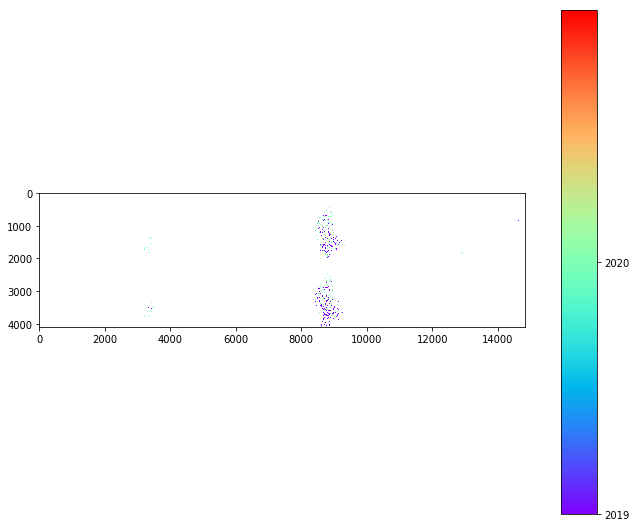

In [143]:
bins = len(idx_starts)
# from matplotlib.pyplot import figure
# figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')

cmap = plt.get_cmap("rainbow")
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(0, bins-1, bins) #third number is the amount of bins in the colorbar 0=0, 6 = ncolors, 7= nyears
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

#norm doesn't work with bins = 2 or less... now the colorbar is ugly, fix it later

if bins == 1:
    im = axes.imshow(breaks_plot_years,cmap=cmap,vmin=0,vmax=bins)
if bins == 2:
    im = axes.imshow(breaks_plot_years,cmap=cmap,vmin=0,vmax=bins)
else:
    im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=bins, norm=norm)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, ticks=range(bins))
labels = cbar_ax.set_yticklabels(ticklist)

plt.savefig("./output/picture.png")
plt.show()



print(bounds)

In [175]:
print(bounds)

[0. 1.]


In [ ]:
# #this doesn't work yet

# output_raster = gdal.GetDriverByName('GTiff').Create('myraster.tif',cols, rows, 1 ,gdal.GDT_Float32)  # Open the file

# output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
# srs = osr.SpatialReference()                 # Establish its coordinate encoding
# srs.ImportFromEPSG(4326)                     # This one specifies WGS84 lat long.
#                                              # Anyone know how to specify the 
#                                              # IAU2000:49900 Mars encoding?
# output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system 
#                                                    # to the file
# output_raster.GetRasterBand(1).WriteArray(breaks_plot_years)   # Writes my array to the raster

# output_raster.FlushCache()

# output_raster

In [121]:
print(breaks_plot_years)
breaks_plot_years_norm = 1/(breaks_plot_years + 0.01)
print(breaks_plot_years_norm)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [122]:
#cmap = plt.get_cmap("Oranges")

#cmaplist = [cmap(i) for i in range(cmap.N)]

#cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# viridis = cm.get_cmap('viridis', 12)
# print(viridis)
# print(viridis(0.56))

viridis = cm.get_cmap('rainbow', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 0])
newcolors[:1, :] = pink
newcmp = ListedColormap(newcolors)

In [182]:
print(latitude)
print(xpixelsize)
print(cols)
print(longitude)
print(ypixelsize)
print(rows)

NameError: name 'latitude' is not defined

In [183]:
print(ts_data.latitude)
print(ts_data.longitude)

40.701497713586164
-8.420088821109099


In [123]:
# this is probs still wrong

from folium.plugins import FloatImage
import base64
latitude = ts_data.latitude
longitude = ts_data.longitude
xpixelsize= ts_data.xpixelsize
ypixelsize= ts_data.ypixelsize
rows = ts_data.nrows
cols = ts_data.ncols

m = folium.folium.Map(location = (latitude,longitude),tiles = "Stamen Terrain",zoom_start=13)

# if not all data is 
#rows = 200
#cols = 200


# bounds = [[lat_min, lon_min], [lat_max, lon_max]]

folium.raster_layers.ImageOverlay(
    image=breaks_plot_years_norm,
    bounds=[[latitude, longitude], [latitude + (rows*xpixelsize), longitude + (cols*xpixelsize)]],
    colormap = newcmp
).add_to(m)
img = "output/picture.png" 


####
resolution, width, height = 75, 4,4
encoded = base64.b64encode(open("output/picture.png", 'rb').read()).decode()
from folium import IFrame

html = '<img src="data:image/png;base64,{}">'.format
iframe = IFrame(html(encoded), width=(width*resolution)+20, height=(height*resolution)+20)
popup = folium.Popup(iframe, max_width=2650)

icon = folium.Icon(color="red", icon="ok")
marker = folium.Marker(location=[latitude, longitude], popup=popup, icon=icon)
marker.add_to(m)
####

m.save(os.path.join('output/PortugalBigger_gpu.html'))
m

KeyboardInterrupt: 